In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import glob
import dask
import matplotlib
import scipy.special as sps
import xagg as xa
import pickle
import matplotlib.gridspec as gridspec

In [44]:
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
# Setupcloseur PBSCluster (Casper)
ncores=1
nmem='16GB'
cluster = PBSCluster(
    n_workers=16,
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='UMSU0012', # Input your project ID here
    walltime='00:30:00', # Amount of wall time
    interface='mgt', # Interface to use
)
# Setup your client
client = Client(cluster)

/glade/work/elkoukah/conda-envs/mynpl/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [45]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/elkoukah/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/elkoukah/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.18.206.35:42875,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/elkoukah/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


# Natural flows

## mizuroute

In [2]:
# routed streamflow

In [2]:
archivedir = '/glade/derecho/scratch/elkoukah/archive/'
sel_period = slice('1980-10-01', '2010-09-30')

In [3]:
# obs
qobs_cr = xr.open_dataset('/glade/work/elkoukah/inputs/obs/crb_reclamation_natflow.nc')
qobs_ca = xr.open_dataset('/glade/work/elkoukah/inputs/obs/ca_qnat_full.nc')

In [4]:
# reclamation_stids = list(qobs.data_vars)
cr_stids = ['09180500', '09315000', '09379500']
comids_crb = pd.read_csv('/glade/work/elkoukah/inputs/obs/crb_stations_comid.csv', dtype={'stid':str})
comids_crb['stid'] = ['0'+stid for stid in comids_crb['stid']]

ds_topology = xr.open_dataset('/glade/work/elkoukah/empirical/optimize/opt_swna/routing/ancillary_data/topology_opt_swna_4km.nc')
comid_list = []
for outlet_id in cr_stids:
    comid = comids_crb[comids_crb['stid']==outlet_id]['COMID'].values[0]
    idx = (ds_topology['segId']==comid).argmax().data
    comid_list.append(idx)

stids_sac = ['SBB', 'FTO', 'AMF'] # Sacremento
# stids_sac = ['SBB', 'FTO', 'YRS', 'AMF'] # Sacremento
# stids_sj = ['CSN', 'MKM', 'SNS', 'TLG', 'MRC', 'SJF', 'KGF'] #San Joaquin
stids_sj = ['TLG', 'SJF', 'KGF'] #San Joaquin
comids_ca = pd.read_csv('/glade/work/elkoukah/inputs/obs/CDEC_Stations_COMID.csv')
ca_stids = stids_sac+stids_sj
for outlet_id in ca_stids:
    comid = comids_ca[comids_ca['STA']==outlet_id]['COMID'].values[0]
    idx = (ds_topology['segId']==comid).argmax().data
    comid_list.append(idx)
    
comid_idx = np.stack(comid_list)

def sel_stid(ds, comid_idx=comid_idx):
    ds_seg = ds.sel(seg=comid_idx)
    return ds_seg['KWTroutedRunoff']

In [5]:
casename = 'prod_swna_4km_new_surfdata_conus404.opt_001'
rofdir = archivedir+casename+'/rof/hist'
dsq = xr.open_mfdataset(rofdir+'/*.h.*nc', preprocess=sel_stid)
dsq_ref1 = dsq.assign_coords({'seg':cr_stids+ca_stids}).compute()

In [6]:
q0_cr = xr.concat([qobs_cr[stid] for stid in cr_stids], dim='stid').sum('stid').sel(time=sel_period)
q0_ca = xr.concat([qobs_ca[stid] for stid in ca_stids], dim='stid').sum('stid').sel(time=sel_period)

In [7]:
# test all time is available for all stations before sum
xr.concat([qobs_ca[stid] for stid in ca_stids], dim='stid').sel(time=sel_period).isnull().sum('time')
# xr.concat([qobs_ca[stid] for stid in ca_stids], dim='stid').mean('time')

<xarray.DataArray 'SBB' (stid: 6)>
array([0, 0, 0, 0, 0, 0])
Dimensions without coordinates: stid

In [8]:
def prep(qmdl, stids_list):
    return [qmdl.sel(seg=stids, time=sel_period).resample(time='1M').mean().sum('seg') for stids in stids_list]
q1_cr, q1_ca = prep(dsq_ref1['KWTroutedRunoff'], [cr_stids, ca_stids])
# q2_cr, q2_ca = prep(dsq_ref2['KWTroutedRunoff'], [cr_stids, ca_stids])
# q3_cr, q3_ca = prep(dsq_ref3['KWTroutedRunoff'], [cr_stids, ca_stids])

In [ ]:
fig = plt.figure(figsize=(10,8))
time = q0_cr.time.astype('datetime64[ns]')

ax = plt.subplot(211)
# ax.plot(time, q2_cr)
# ax.plot(time, q3_cr,  marker='.')
ax.plot(time, q0_cr, c='k', marker='.')
ax.plot(time, q1_cr)

ax.grid()

ax = plt.subplot(212)
ax.plot(time, q1_ca)
# ax.plot(time, q2_ca)
# ax.plot(time, q3_ca)
ax.plot(time, q0_ca, c='k')
ax.grid()

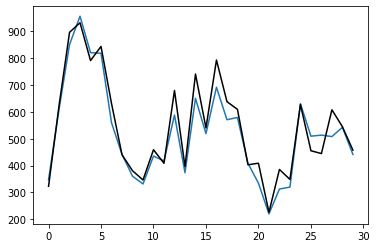

In [16]:
plt.plot(q1_cr.resample(time='A-SEP').mean())
plt.plot(q0_cr.resample(time='A-SEP').mean(), c='k')

In [13]:
def calc_metric(qm, qo):
    b = qm.mean()/qo.mean()
    r = np.corrcoef(qm, qo)[0,1]
    a = qm.std()/qo.std()
    nse = 1 - np.sum((qm.data-qo.data)**2)/np.sum((qo-qo.mean().data)**2)
    kge = 1 - np.sqrt((b-1)**2 + (r-1)**2 + (a-1)**2)
    return b, r, nse, kge
#
print('CR (beta, r, nse, kge)')
print('base: %.3f, %.3f, %.3f, %.3f' % calc_metric(q1_cr, q0_cr))
# print('new:  %.3f, %.3f, %.3f' % calc_metric(q2_cr, q0_cr))

print('CA')
print('base: %.3f, %.3f, %.3f, %.3f' % calc_metric(q1_ca, q0_ca))
# print('new:  %.3f, %.3f, %.3f' % calc_metric(q2_ca, q0_ca))

CR (beta, r, nse, kge)
base: 0.956, 0.822, 0.649, 0.816
CA
base: 0.816, 0.940, 0.830, 0.793


In [18]:
print('CR (beta, r, nse, kge)')
print('base: %.3f, %.3f, %.3f, %.3f' % calc_metric(q1_cr.resample(time='A-SEP').mean(), q0_cr.resample(time='A-SEP').mean()))
print('CA')
print('base: %.3f, %.3f, %.3f, %.3f' % calc_metric(q1_ca.resample(time='A-SEP').mean(), q0_ca.resample(time='A-SEP').mean()))

CR (beta, r, nse, kge)
base: 0.956, 0.971, 0.925, 0.938
CA
base: 0.816, 0.993, 0.845, 0.815


## CaMa

### analysis

In [3]:
start_date = "1980-10-01"
end_date = "2020-09-30"
tdelta = slice(start_date, end_date)

In [4]:
def get_obs(indir_obs, inf_qobs, inf_stattrs, tdelta):
    """
    Return stations obs dataset,
    """
    df = pd.read_csv(indir_obs + inf_qobs)
    st_ids = df.iloc[0, 1:].values
    df0 = df.iloc[5:-5]
    df0.columns = ["date"] + st_ids.tolist()
    index = pd.to_datetime(df0.date)
    df0.loc[:, "date"] = index
    df0.rename(columns={"date": "time"}, inplace=True)
    df0.set_index("time", inplace=True)
    df1 = df0.astype("float")
    df_sts = pd.read_csv(
        indir_obs + inf_stattrs, dtype={"stid": str, "lon": float, "lat": float}
    )
    st_ids_eval = df_sts["stid"]
    df1_sts = df1.loc[tdelta, st_ids_eval]
    month_length = df1_sts.index.days_in_month.values
    df1_sts = df1_sts / (70.07 * month_length[:, np.newaxis])  # m3/s
    qobs = df1_sts.to_xarray()
    df_sts.set_index("stid", inplace=True)
    return qobs, st_ids_eval, df_sts

indir_obs = "/glade/work/elkoukah/inputs/obs/"
inf_qobs = "NaturalFlows1906-2020_20221215.csv"
inf_stattrs = "crb_stations_wgs84.csv"
mdl_varname = "outflw"
cellsize = 0.05
dt = "1M"
archivedir = "/glade/derecho/scratch/elkoukah/archive/"
# CR observations
qcr_t, stn_eval, df_sts_cr = get_obs(indir_obs, inf_qobs, inf_stattrs, tdelta)

/glade/work/elkoukah/conda-envs/mynpl/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/glade/work/elkoukah/conda-envs/mynpl/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [5]:
# CA observations
comids_ca = pd.read_csv('/glade/work/elkoukah/inputs/obs/CDEC_Stations_COMID.csv')
comids_ca = comids_ca.set_index('STA')
comids_ca = comids_ca.drop('CLD')
df_sts_ca = comids_ca.reset_index()[['STA','Latitude','Longitude']].rename(columns={'STA':'stid','Latitude':'lat','Longitude':'lon'})

qca = xr.open_dataset('/glade/work/elkoukah/inputs/obs/ca_qnat_full.nc')
qca_t = qca.sel(time=tdelta)
qca_t['time'] = qcr_t.time

In [44]:
# Camels observations
def read_camels(camels_dir_qobs, camels_coord_file, camels_name_file):
    df0 = pd.read_csv(camels_coord_file, delimiter=';', dtype={'gauge_id':str})
    df0 = df0.set_index('gauge_id')
    df_name = pd.read_csv(camels_name_file, delimiter=';', dtype=str)
    df_name_sw = df_name[df_name['huc_02'].isin(['14','15','18'])]
    df1 = df0.loc[df_name_sw['gauge_id']]

    huc = ['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18']
    sel_gauges = df1.index.tolist()
    camels_qobs_files = []
    for i in huc:
        files = os.listdir(camels_dir_qobs+i+'/')
        filespath = [camels_dir_qobs+i+'/'+f for f in files if (f.split('_')[0] in sel_gauges)] 
        camels_qobs_files.extend(filespath)

    dfs_list = []
    for fpath in camels_qobs_files:
        gid = os.path.basename(fpath).split('_')[0]
        df0_obs = pd.read_csv(fpath, sep='\s+', names=['gauge_id', 'year', 'month', 'day', gid, 'flag'])
        df0_obs['time'] = pd.to_datetime(df0_obs[['year','month','day']])
        df0_obs = df0_obs.set_index('time')
        df0_obs = df0_obs.drop(['gauge_id', 'year','month','day','flag'], axis=1)
        dfs_list.append(df0_obs)

    df_obs = pd.concat(dfs_list, axis=1)
    ds_obs = df_obs.to_xarray()
    return ds_obs.where(ds_obs>=0), df1

camels_coord_file = '/glade/work/elkoukah/inputs/obs/CAMELS/camels_topo.txt'
camels_name_file = '/glade/work/elkoukah/inputs/obs/CAMELS/camels_name.txt'
camels_dir_qobs = '/glade/work/elkoukah/inputs/obs/CAMELS/usgs_streamflow/'
ds_obs_camels, df_attrs_camels = read_camels(camels_dir_qobs, camels_coord_file, camels_name_file)
qcamels_t = ds_obs_camels.sel(time=tdelta).resample(time='1M').mean()

df_sts_camels = df_attrs_camels[['gauge_lon','gauge_lat']].reset_index()
df_sts_camels = df_sts_camels.rename(columns={'gauge_id':'stid', 'gauge_lon':'lon', 'gauge_lat':'lat'})

In [45]:
# merge

df_sts = pd.concat([df_sts_cr.reset_index(), df_sts_ca, df_sts_camels]).set_index('stid')
df_sts_ca_cr = pd.concat([df_sts_cr.reset_index(), df_sts_ca]).set_index('stid')

qobs = xr.merge([qcr_t, qca_t, qcamels_t])

In [46]:
df_sts.to_csv('out/natural_flow_gages_swna.csv')
df_sts_ca_cr.to_csv('out/natural_flow_gages_cr_ca.csv')
qobs.to_netcdf('out/natural_flow_swna.nc')

In [8]:
# # fix stations
# df_sts.loc["09180500"] = [-109.375, 38.725] # Colorado River Near Cisco UT
# df_sts.loc["09379500"] = [-109.925, 37.175] # San Juan River Near Bluff, UT
# df_sts.loc['09211200'] = [-110.075, 42.025]
# df_sts.loc['AMN'] = [-120.975, 38.975]
# df_sts.loc['FTC'] = [-120.625, 39.775]

# df_sts_ca_cr.loc['09211200'] = df_sts.loc['09211200']
# df_sts_ca_cr.loc['AMN'] = df_sts.loc['AMN']
# df_sts_ca_cr.loc['FTC'] = df_sts.loc['FTC']
# df_sts.to_csv('natural_flow_gages.csv')

In [9]:
# model

In [8]:
# SW
mapdir = "/glade/work/elkoukah/empirical/reservoirs/cama400/map/SW_3min/"
diminfo = "diminfo_test-CR4km.txt"
res = 0.05
x0 = -124.950
x1 = -105.000
y0 = 30.000
y1 = 44.950
lats = np.arange(y0 + res / 2, y1, res)[::-1]
lons = np.arange(x0 + res / 2, x1, res)
nlat, nlon = lats.size, lons.size

def read_outflw(rofdir, y1, y2):
    time = pd.date_range(str(y1) + "-01-01", str(y2) + "-12-31", freq="D",)
    leapday_idx = (time.month == 2) & (time.day == 29)
    time = time[~leapday_idx]
    list_outflw = []
    for year in range(y1, y2 + 1):
        qfile = rofdir + "outflw%i.bin" % year
        outflw = np.fromfile(qfile, "<f").reshape(-1, nlat, nlon)
        outflw[outflw > 1.0e19] = 0
        list_outflw.append(outflw)
    outflw = xr.DataArray(np.vstack(list_outflw), dims=("time", "lat", "lon"), coords={"time": time, "lat": lats, "lon": lons},)
    return outflw

def get_qmdl(outflw, tdelta, df_sts, cellsize):
    qsim_grid = outflw.sel(time=tdelta)
    tmp = {}
    for stn in df_sts.index:
        dfsti = df_sts.loc[stn]
        stx = dfsti["lon"]
        sty = dfsti["lat"]
        xi = np.isclose(stx, lons, atol=cellsize / 2, rtol=0)
        yi = np.isclose(sty, lats, atol=cellsize / 2, rtol=0)
        xx, yy = lons[xi], lats[yi]
        qsim_sti = qsim_grid.sel(lat=yy, lon=xx)
        qsim_sti = qsim_sti.squeeze(dim=("lat", "lon"))
        tmp[stn] = qsim_sti.reset_coords(('lat','lon'), drop=True)
    qmdl = xr.Dataset(tmp)
    return qmdl

In [9]:
def get_qmdl_obs(outflw, tdelta, df_sts, qobs, cellsize):
    qsim_grid = outflw.sel(time=tdelta)
    tmp = {}
    for stn in df_sts.index:
        dfsti = df_sts.loc[stn]
        stx = dfsti["lon"]
        sty = dfsti["lat"]
        xi = np.where(np.isclose(stx, lons, atol=cellsize, rtol=0))[0]
        yi = np.where(np.isclose(sty, lats, atol=cellsize, rtol=0))[0]
        # xx, yy = lons[xi], lats[yi]
        qsim_sti = qsim_grid.isel(lat=yi, lon=xi)
        # qsim_sti = qsim_sti.squeeze(dim=("lat", "lon"))
        
        # calculate nse/bias
        qsim_mon = qsim_sti.resample(time='1M').mean()
        x, y = qobs[stn].data, qsim_mon.data
        ma = np.isnan(x)
        x, y = x[~ma], y[~ma]
        if x.size>=60:
            # nse = 1 - ((y.T-x)**2).mean(axis=-1)/(x.std())**2
            nse = y.T.mean(axis=-1)[:,:,None]/x.mean()
            qsim_sti = qsim_sti.stack(ngrd=('lat','lon')).isel(ngrd=nse.T.argmax())
            # if stn=='09402000':
            #     print(stx, sty, qsim_sti.mean('time'), nse.T)
            qsim_sti = qsim_sti.reset_coords('ngrd', drop=True)
        else:
            xi = np.isclose(stx, lons, atol=cellsize/2, rtol=0).argmax()
            yi = np.isclose(sty, lats, atol=cellsize/2, rtol=0).argmax()
            qsim_sti = qsim_grid.isel(lat=yi, lon=xi).reset_coords(('lat','lon'), drop=True)

        tmp[stn] = qsim_sti
    qmdl = xr.Dataset(tmp)
    return qmdl

In [10]:
y1 = int(start_date[:4])
y2 = int(end_date[:4])

caseid_nat = "prod_swna_4km_new_surfdata_conus404.ref_001"
rofdir_nat = archivedir + caseid_nat + "/rof/NAT_3min_1980-2020/"
outflw_ref = read_outflw(rofdir_nat, y1, y2)

caseid_nat = "prod_swna_4km_new_surfdata_conus404.opt_001"
rofdir_nat = archivedir + caseid_nat + "/rof/NAT_3min_1980-2020_fixlat/"
outflw_opt = read_outflw(rofdir_nat, y1, y2)

In [11]:
qmdl_ref1 = get_qmdl_obs(outflw_ref, tdelta, df_sts_ca_cr, qobs, cellsize)
qmdl_opt1 = get_qmdl_obs(outflw_opt, tdelta, df_sts_ca_cr, qobs, cellsize)

In [ ]:
# outflw_opt.isel(lat=180, lon=267).groupby('time.month').mean().plot()
# outflw_ref.isel(lat=180, lon=267).groupby('time.month').mean().plot()
# qobs[stn].groupby('time.month').mean().plot(c='k')
# stn = '09402000'
# qobs[stn].groupby('time.month').mean().plot(c='k')
# qmdl_ref1[stn].groupby('time.month').mean().plot()
# qmdl_opt1[stn].groupby('time.month').mean().plot()

In [10]:
# Route runoff for Camels

import xagg as xa
import scipy.special as sps  

def ds_aave_polygon(ds,gdf):
    weightmap = xa.pixel_overlaps(ds,gdf)
    aggregated = xa.aggregate(ds, weightmap)
    ds_aave = aggregated.to_dataset()
    return ds_aave
    
def route(da, shape=2.5, scale=1):
    nt = da.time.size
    t = np.arange(0, nt)
    y = t**(shape-1)*(np.exp(-t/scale) /  
                         (sps.gamma(shape)*scale**shape))
    q = np.convolve(y, da.data[:-1], mode='full')
    q = xr.DataArray(q[:nt-1], dims=('time',), coords={'time':da.time[:nt-1]}, name='Q')
    return q

def calc_discharge(camels_stations, gdf_camels, dsrof, df_attrs_camels, res=0.04):
    # Discharge at Camels
    dict_q = {}
    for basin in camels_stations:
        print('area averaging:', basin)
        gdfi = gdf_camels.loc[int(basin)]
        geom = gpd.GeoDataFrame({'tag': [basin], 'geometry': [gdfi.geometry]}, crs="EPSG:4326")
        minx,miny,maxx,maxy = geom.bounds.values[0]
        minx,miny,maxx,maxy = minx-res,miny-res,maxx+res,maxy+res
        dsh_bounds = dsrof.sel(lat=slice(miny,maxy), lon=slice(minx+360,maxx+360))
        dsh_aave = ds_aave_polygon(dsh_bounds[['QRUNOFF']], geom)
        print('routing runoff:', basin)
        rof = dsh_aave['QRUNOFF'][0]*24*60**2
        discharge = route(rof)
        A = df_attrs_camels.loc[basin,'area_gages2']*10**6
        fc = (10**-3)*A/(24*60**2)
        dict_q[basin] = discharge*fc
    return dict_q

In [13]:
caseid_nat = "prod_swna_4km_new_surfdata_conus404.ref_001"
roffile = archivedir + caseid_nat + "/lnd/hist/QRUNOFF.nc"
dsrof_ref = xr.open_dataset(roffile).load()

In [14]:
caseid_nat = "prod_swna_4km_new_surfdata_conus404.opt_001"
roffile = archivedir + caseid_nat + "/lnd/hist/QRUNOFF.nc"
dsrof_opt = xr.open_dataset(roffile).load()

In [15]:
camels_stations = df_attrs_camels.index.tolist()
gdf_camels = gpd.read_file('/glade/work/elkoukah/inputs/obs/CAMELS/HCDN_nhru_final_671.shp')
gdf_camels = gdf_camels.set_index('hru_id')

In [16]:
qcamels_dict_ref = calc_discharge(camels_stations, gdf_camels, dsrof_ref, df_attrs_camels, res=0.04)

area averaging: 09034900
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...
success!
aggregating QRUNOFF...
all variables aggregated to polygons!
routing runoff: 09034900
area averaging: 09035800
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...
success!
aggregating QRUNOFF...
all variables aggregated to polygons!
routing runoff: 09035800
area averaging: 09035900
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...
success!
aggregating QRUNOFF...
all variables aggregated to polygons!
routing runoff: 09035900
area averaging: 09047700
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...

In [17]:
qcamels_dict_opt = calc_discharge(camels_stations, gdf_camels, dsrof_opt, df_attrs_camels, res=0.04)

area averaging: 09034900
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...
success!
aggregating QRUNOFF...
all variables aggregated to polygons!
routing runoff: 09034900
area averaging: 09035800
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...
success!
aggregating QRUNOFF...
all variables aggregated to polygons!
routing runoff: 09035800
area averaging: 09035900
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...
success!
aggregating QRUNOFF...
all variables aggregated to polygons!
routing runoff: 09035900
area averaging: 09047700
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...

In [18]:
qcamels_ref = xr.Dataset(qcamels_dict_ref)
qcamels_opt = xr.Dataset(qcamels_dict_opt)
qcamels_ref['time'] = qcamels_ref.time.astype('datetime64[ns]')
qcamels_opt['time'] = qcamels_opt.time.astype('datetime64[ns]')
qcamels_ref_t = qcamels_ref.sel(time=tdelta)
qcamels_opt_t = qcamels_opt.sel(time=tdelta)

In [19]:
# merge modelled discharge

In [20]:
qmdl_ref = xr.merge([qmdl_ref1, qcamels_ref_t]) 
qmdl_opt = xr.merge([qmdl_opt1, qcamels_opt_t])
qmdl_ref_mon = qmdl_ref.resample(time='1M').mean()
qmdl_opt_mon = qmdl_opt.resample(time='1M').mean()

In [21]:
qmdl_ref.to_netcdf('out/qmdl_ref_swna.nc')
qmdl_opt.to_netcdf('out/qmdl_opt_swna.nc')

In [22]:
# metrics

In [23]:
def calc_mkge(x,y):
    r2 = np.mean((y-y.mean()).T*(x-x.mean()))/(y.std()*x.std())
    beta = y.mean()/x.mean()
    beta_p = (y.mean()-x.mean())/x.std()
    sigma = y.std()/x.std()
    mkge = 1 - np.sqrt(((r2-1)**2 + (sigma-1)**2 + beta_p**2))
    nse = 1 - ((y-x)**2).mean()/(x.std())**2
    return [nse, mkge, r2, beta_p, sigma, beta]


qmdl_ref_mon["time"] = qobs.time
qmdl_opt_mon["time"] = qobs.time
qobs_wy = qobs.resample(time='A-SEP').mean()
qmdl_ref_wy = qmdl_ref_mon.resample(time='A-SEP').mean()
qmdl_opt_wy = qmdl_opt_mon.resample(time='A-SEP').mean()

sel_sts = df_sts.index
metrics = ['nse', 'mkge', 'r', 'beta_p', 'sigma', 'beta', 'nse_wy', 'r_wy']
cols = pd.MultiIndex.from_product([['ref','opt'], metrics])
df_metrics = pd.DataFrame(np.full((len(sel_sts), len(cols)), np.nan), columns=cols, index=sel_sts)

for c, qmdl in zip(['ref','opt'], [qmdl_ref_mon, qmdl_opt_mon]):
    for i, st in enumerate(sel_sts):
        y = qmdl[st].data
        x = qobs[st].data
        ma = np.isnan(x)+np.isnan(y)
        x, y = x[~ma], y[~ma]
        if x.size<120:
            continue
        df_metrics.loc[st, (c, metrics[:-2])] = calc_mkge(x,y)

for c, qmdl in zip(['ref','opt'], [qmdl_ref_wy, qmdl_opt_wy]):
    for i, st in enumerate(sel_sts):
        y = qmdl[st].data
        x = qobs_wy[st].data
        ma = np.isnan(x)+np.isnan(y)
        x, y = x[~ma], y[~ma]
        if x.size<10:
            continue
        df_metrics.loc[st, (c, metrics[-2:])] = np.array(calc_mkge(x,y))[[0,2]]

In [24]:
df_metrics.to_csv('./out/streamflow_metrics_nat_flow_swna.csv')

In [60]:
df_metrics.loc[df_sts_ca['stid']].loc[:, ('opt','mkge')].sort_values().iloc[:40]

stid
SRS   -5.949143
AMN   -1.151350
OWL   -1.130649
EFC   -0.404294
TRF   -0.371644
CSN   -0.188415
KGC   -0.147926
FTC   -0.034539
WWR    0.017645
MSS    0.068997
STB    0.087755
SWH    0.093071
KLO    0.105937
ANT    0.148513
SCC    0.154932
EWR    0.168081
AMA    0.175876
ANM    0.217664
NCD    0.266864
YBJ    0.323654
PSH    0.370344
RRH    0.373667
PLK    0.375700
ASV    0.390417
FPR    0.391760
TLM    0.437009
FPL    0.483690
CYO    0.486823
MBS    0.537938
FTP    0.549867
NPH    0.554596
YBM    0.589906
YBG    0.603652
FRD    0.613197
YBS    0.635713
ERS    0.637033
KWT    0.645279
SCU    0.653053
WFC    0.656399
SIS    0.675632
Name: (opt, mkge), dtype: float64

In [288]:
df_metrics.loc[df_sts_ca_cr.index].describe()

ref                                                    \
                nse         mkge          r       beta_p        sigma   
count  9.400000e+01    94.000000  94.000000    94.000000    94.000000   
mean  -6.335109e+04   -26.709767   0.695040    22.163953    17.352932   
std    6.141208e+05   251.448399   0.200404   204.030622   146.992990   
min   -5.954131e+06 -2438.544168   0.034137    -0.524791     0.102218   
25%   -5.052765e+00    -1.197856   0.594263     0.281515     1.350474   
50%   -1.702191e+00    -0.153865   0.724728     0.738458     1.725227   
75%    2.121356e-01     0.441329   0.858808     1.321054     2.470741   
max    9.437664e-01     0.934079   0.972077  1979.189678  1427.247886   

                                                      opt               \
              beta        nse_wy       r_wy           nse         mkge   
count    94.000000  9.400000e+01  94.000000  9.400000e+01    94.000000   
mean     23.821626 -3.688575e+05   0.930691 -1.234798e+04   -11.138609   
std     205.437188  3.575932e+06   0.084630  1.197077e+05   110.969189   
min       0.100716 -3.466997e+07   0.539749 -1.160610e+06 -1075.528423   
25%       1.377127 -1.409378e+01   0.923207 -4.186083e-02     0.273280   
50%       1.830086 -2.167963e+00   0.957236  5.612402e-01     0.635324   
75%       2.719277  4.953196e-01   0.980778  7.800435e-01     0.786458   
max    1994.133119  9.588637e-01   0.994222  8.899879e-01     0.905050   

                                                                               
               r      beta_p       sigma        beta        nse_wy       r_wy  
count  94.000000   94.000000   94.000000   94.000000  9.400000e+01  94.000000  
mean    0.831061    8.445668    9.255621    9.600208 -5.984685e+04   0.930902  
std     0.149326   80.403925   76.532767   80.964073  5.802122e+05   0.090312  
min    -0.143011   -0.547035    0.084034    0.062599 -5.625369e+06   0.479288  
25%     0.772051   -0.145840    0.893953    0.823528  1.438009e-01   0.923099  
50%     0.885406   -0.005946    1.113515    0.993285  6.481865e-01   0.960364  
75%     0.917972    0.140559    1.567928    1.152017  8.626276e-01   0.981914  
max     0.959533  779.667359  743.314589  786.160135  9.743371e-01   0.990896

In [98]:
abs(df_metrics.loc[:, ('ref','beta')]-1).median(), abs(df_metrics.loc[:, ('opt','beta')]-1).quantile(.5)

(0.9697291407107183, 0.18347951872297175)

In [173]:
abs(df_metrics.loc[df_sts_ca_cr.index, ('ref','beta')]-1).median(), abs(df_metrics.loc[df_sts_ca_cr.index, ('opt','beta')]-1).quantile(.5)

(0.7290313887702664, 0.18310541720681495)

In [18]:
import xagg as xa
import scipy.special as sps  

def ds_aave_polygon(ds, gdf, weightmap=None):
    if weightmap is None:
        weightmap = xa.pixel_overlaps(ds, gdf)
    aggregated = xa.aggregate(ds, weightmap)
    ds_aave = aggregated.to_dataset()
    return weightmap, ds_aave

In [12]:
# Climate sensitivity 

In [20]:
gdf_ucrb = gpd.read_file('/glade/work/elkoukah/inputs/domain/shapefile/ucrb_epsg4326.shp')
gdf_ns = gpd.read_file('/glade/work/elkoukah/inputs/domain/shapefile/northern_sierras_amf-sbb-yrs-fto.shp')
gdf_ns = gpd.GeoDataFrame({'basin':['Northern Sierras'], 'geometry':[gdf_ns.unary_union]}, crs='EPSG:4326')

In [ ]:
# Observations

# northern sierras
gdf_ns = gpd.read_file('/glade/work/elkoukah/inputs/domain/shapefile/northern_sierras_amf-sbb-yrs-fto.shp')
gdf_ns = gpd.GeoDataFrame({'basin':['Northern Sierras'], 'geometry':[gdf_ns.unary_union]}, crs='EPSG:4326')
minx, miny, maxx, maxy = gdf_ns.bounds.values[0]

idir = '/glade/derecho/scratch/elkoukah/inputs/prism/postprocess/'
ppt = xr.load_dataarray(idir+'ppt.nc')
ppt_bb = ppt.sel(lat=slice(miny,maxy), lon=slice(minx,maxx)).compute()
prcp_prism = ds_aave_polygon(ppt_bb, gdf_ns)

ns_qobs = (qobs['AMF']+qobs['SBB']+qobs['YRS']+qobs['FTO'])
ns_precip = prcp_prism['ppt'].sel(time=tdelta)[0]

# ucrb
dict_prism = pickle.load(open('/glade/derecho/scratch/elkoukah/inputs/prism/postprocess/prism_ucrb.pkl', 'rb'))
prism_ppt = dict_prism['prism_ppt']
ucrb_precip = prism_ppt.sel(time=tdelta)
ucrb_qobs = qobs['09380000']

In [ ]:
gdf_ucrb = gpd.read_file('/glade/work/elkoukah/inputs/domain/shapefile/ucrb_epsg4326.shp')
minx, miny, maxx, maxy = gdf_ucrb.bounds.values[0]
ppt_bb = ppt.sel(lat=slice(miny,maxy), lon=slice(minx,maxx)).compute()
prcp_prism = ds_aave_polygon(ppt_bb, gdf_ucrb)
ucrb_precip = prcp_prism['ppt'].sel(time=tdelta)[0]

In [55]:
dict_out = {'ucrb':(ucrb_precip, ucrb_qobs), 'ns':(ns_precip, ns_qobs)}
pickle.dump(dict_out, open('out/obs_precip_q_ucrb_ns.pkl', 'wb'))

In [43]:
# Simulations

In [13]:
archive_dir = '/glade/derecho/scratch/elkoukah/archive/'
casename_opt = 'prod_swna_4km_new_surfdata_conus404.opt_001'
casename_ref = 'prod_swna_4km_new_surfdata_conus404.ref_001'

def preprocess(ds):
    return ds[['RAIN', 'SNOW']]

files = sorted(glob.glob(archive_dir+casename_ref+'/lnd/hist/'+casename_ref+'.clm2.h0.*.nc'))
h0_ref = xr.open_mfdataset(files, parallel=True, preprocess=preprocess)
h0_ref['lon'] = h0_ref.lon-360

In [21]:
minx, miny, maxx, maxy = gdf_ucrb.bounds.values[0]
h0_ref_bbox = h0_ref.sel(lat=slice(miny,maxy), lon=slice(minx, maxx)).compute()
weightmap, h0_ref_aave = ds_aave_polygon(h0_ref_bbox, gdf_ucrb)
ucrb_ppt_ref = (h0_ref_aave['RAIN']+h0_ref_aave['SNOW'])*24*60**2

creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...
success!
aggregating RAIN...
aggregating SNOW...
all variables aggregated to polygons!


In [23]:
minx, miny, maxx, maxy = gdf_ns.bounds.values[0]
h0_ref_bbox = h0_ref.sel(lat=slice(miny,maxy), lon=slice(minx, maxx)).compute()
ns_weightmap, h0_ref_aave = ds_aave_polygon(h0_ref_bbox, gdf_ns)
ns_ppt_ref = (h0_ref_aave['RAIN']+h0_ref_aave['SNOW'])*24*60**2

creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...
success!
aggregating RAIN...
aggregating SNOW...
all variables aggregated to polygons!


In [26]:
dict_out = {'ucrb':ucrb_ppt_ref.sel(time=tdelta)[0], 'ns':ns_ppt_ref.sel(time=tdelta)[0]}
pickle.dump(dict_out, open('out/conus404_precip_ucrb_ns.pkl', 'wb'))

In [32]:
dict_out = {'ucrb':weightmap, 'ns':ns_weightmap}
pickle.dump(dict_out, open('out/ucrb_ns_weightmap.pkl', 'wb'))

### plots

In [30]:
# Plot natural vs observed

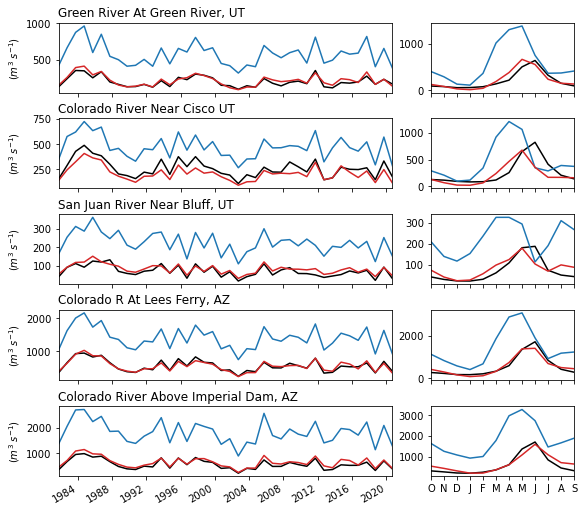

In [174]:
cr_sel_stations = {
    "09315000": "Green River At Green River, UT",
    "09180500": "Colorado River Near Cisco UT",
    "09379500": "San Juan River Near Bluff, UT",
    "09380000": "Colorado R At Lees Ferry, AZ",
    "09429490": "Colorado River Above Imperial Dam, AZ",
}
months = np.arange(12)
idx = np.append(months[9:], months[:9])

qobs_sel = qobs[list(cr_sel_stations.keys())]
qmdl_ref_sel = qmdl_ref_mon[list(cr_sel_stations.keys())]
qmdl_opt_sel = qmdl_opt_mon[list(cr_sel_stations.keys())]
qmdl_ref_sel["time"] = qobs_sel.time
qmdl_opt_sel["time"] = qobs_sel.time

xx_ann = qobs_sel.resample(time='A-SEP').mean()
yyref_ann = qmdl_ref_mon.resample(time='A-SEP').mean()
yyopt_ann = qmdl_opt_mon.resample(time='A-SEP').mean()

xx_annc = qobs_sel.groupby("time.month").mean()
yyref_annc = qmdl_ref_mon.groupby("time.month").mean()
yyopt_annc = qmdl_opt_mon.groupby("time.month").mean()

sel_sts = list(cr_sel_stations.keys())
fig, axes = plt.subplots(len(sel_sts), 2, sharex="col", constrained_layout=True,
                         sharey=False, figsize=(8, 7), gridspec_kw={'width_ratios':[.7,.3]})
# plt.subplots_adjust(wspace=0.05)
for i in range(len(sel_sts)):
    ax1 = axes[i, 1]
    ax1.plot(xx_annc[sel_sts[i]].data[idx], c="k", label="Observed (Reclamation)")
    ax1.plot(yyref_annc[sel_sts[i]].data[idx], label="Simulated (refCLM-CaMa-Flood)")
    ax1.plot(yyopt_annc[sel_sts[i]].data[idx], c='tab:red', label="Simulated (optCLM-CaMa-Flood)")
    ax1.set_xticks(range(12))
    ax1.set_xticklabels(["O","N","D","J","F","M","A","M","J","J","A","S",])

    ax2 = axes[i, 0]
    xx_ann[sel_sts[i]].plot(ax=ax2, c="k")
    yyref_ann[sel_sts[i]].plot(ax=ax2)
    yyopt_ann[sel_sts[i]].plot(ax=ax2, c='tab:red')
    ax2.set_ylabel(None)
    ax2.set_xlabel(None)
    # ax2.annotate(cr_sel_stations[sel_sts[i]], (0.015, 1), xycoords="axes fraction")
    ax2.set_ylabel("($m^3\;s^{-1}$)")
    ax2.set_title(cr_sel_stations[sel_sts[i]], loc='left')
for ax in axes.ravel():
    ax.margins(x=0)

fig.align_ylabels(axes[:, 0])
# fig.savefig("./figs/nat_opt_ref_cr.png", dpi=300, bbox_inches="tight",)

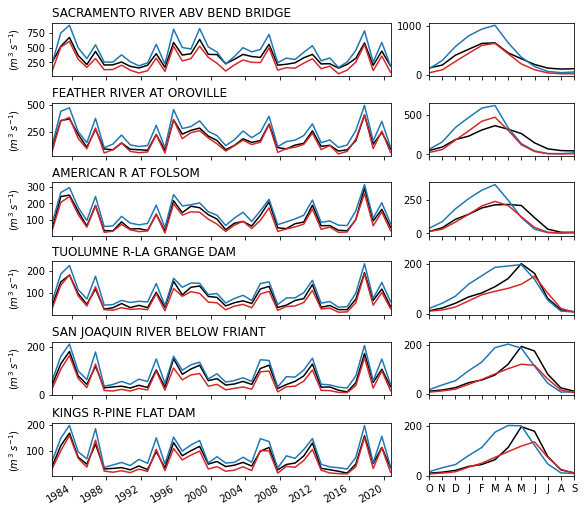

In [175]:
sel_sts = ['SBB', 'FTO', 'AMF', # Sacremento
           'TLG', 'SJF', 'KGF'] #San Joaquin
ca_sel_stations = comids_ca.loc[sel_sts]['Station Name'].to_dict()
months = np.arange(12)
idx = np.append(months[9:], months[:9])

qobs_sel = qobs[sel_sts]
qmdl_ref_sel = qmdl_ref_mon[sel_sts]
qmdl_opt_sel = qmdl_opt_mon[sel_sts]
qmdl_ref_sel["time"] = qobs_sel.time
qmdl_opt_sel["time"] = qobs_sel.time

xx_ann = qobs_sel.resample(time='A-SEP').mean()
yyref_ann = qmdl_ref_mon.resample(time='A-SEP').mean()
yyopt_ann = qmdl_opt_mon.resample(time='A-SEP').mean()

xx_annc = qobs_sel.groupby("time.month").mean()
yyref_annc = qmdl_ref_mon.groupby("time.month").mean()
yyopt_annc = qmdl_opt_mon.groupby("time.month").mean()

fig, axes = plt.subplots(len(sel_sts), 2, sharex="col", constrained_layout=True,
                         sharey=False, figsize=(8, 7), gridspec_kw={'width_ratios':[.7,.3]})
# plt.subplots_adjust(wspace=0.05)
for i in range(len(sel_sts)):
    ax1 = axes[i, 1]
    ax1.plot(xx_annc[sel_sts[i]].data[idx], c="k", label="Observed (Reclamation)")
    ax1.plot(yyref_annc[sel_sts[i]].data[idx], label="Simulated (refCLM-CaMa-Flood)")
    ax1.plot(yyopt_annc[sel_sts[i]].data[idx], c='tab:red', label="Simulated (optCLM-CaMa-Flood)")
    ax1.set_xticks(range(12))
    ax1.set_xticklabels(["O","N","D","J","F","M","A","M","J","J","A","S",])

    ax2 = axes[i, 0]
    xx_ann[sel_sts[i]].plot(ax=ax2, c="k")
    yyref_ann[sel_sts[i]].plot(ax=ax2)
    yyopt_ann[sel_sts[i]].plot(ax=ax2, c='tab:red')
    ax2.set_ylabel(None)
    ax2.set_xlabel(None)
    ax2.set_ylabel("($m^3\;s^{-1}$)")
    ax2.set_title(ca_sel_stations[sel_sts[i]], loc='left')
for ax in axes.ravel():
    ax.margins(x=0)

fig.align_ylabels(axes[:, 0])
# fig.savefig("./figs/nat_opt_ref_ca.png", dpi=300, bbox_inches="tight",)

In [17]:
# Maps

<AxesSubplot:>

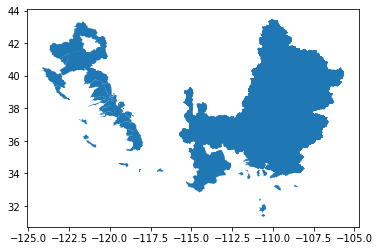

In [119]:
gdf_geoms_union.plot()

# Snow cover

In [7]:
from shapely.geometry import Polygon
def grid_polygon_intersect(lats, lons, res, geom):
    gridcells = [Polygon(((x-res, y-res),
                      (x-res, y+res),
                      (x+res, y+res),
                      (x+res,y-res),
                      (x-res, y-res))) for x,y in zip(lons, lats)]
    ngrd = len(gridcells)
    mask = np.zeros((ngrd,), dtype=int)
    print('searching for grid intersections ...')
    for ii in range(ngrd):
        mask[ii] = geom.intersects(gridcells[ii])
    print('intersecting grid total:', mask.sum(), 'out of', ngrd)
    return mask

## SWE

In [8]:
def preprocess(ds):
    return ds[['H2OSNO']]

archive_dir = '/glade/derecho/scratch/elkoukah/archive/'

casename = 'prod_swna_4km_new_surfdata_conus404.opt_001'
files = sorted(glob.glob(archive_dir+casename+'/lnd/hist/'+casename+'.clm2.h1.*.nc'))[:-1]
h1_opt = xr.open_mfdataset(files, parallel=True, preprocess=preprocess)

casename = 'prod_swna_4km_new_surfdata_conus404.ref_001'
files = sorted(glob.glob(archive_dir+casename+'/lnd/hist/'+casename+'.clm2.h1.*.nc'))[:-1]
h1_ref = xr.open_mfdataset(files, parallel=True, preprocess=preprocess)

In [9]:
h1_opt['lon'] = h1_opt['lon']-360
h1_ref['lon'] = h1_ref['lon']-360

In [10]:
h1_opt = h1_opt.compute()
h1_ref = h1_ref.compute()

In [26]:
ds_stations = xr.open_dataset('/glade/work/elkoukah/inputs/obs/snowPillowSWE_westernNA_level2_ncc.nc')

lons, lats = ds_stations['longitude'][0].data, ds_stations['latitude'][0].data
ma = np.isnan(lons)+np.isnan(lats)
lons = lons[~ma]
lats = lats[~ma]
ds_stations = ds_stations.sel(sites=(~ma))

In [15]:
list_opt = []
list_ref = []
for x, y in zip(lons, lats):
    list_opt.append(h1_opt.sel(lon=x, lat=y, method='nearest').drop(('lon','lat')))
    list_ref.append(h1_ref.sel(lon=x, lat=y, method='nearest').drop(('lon','lat')))
da_opt = xr.concat(list_opt, dim='site')
da_ref = xr.concat(list_ref, dim='site')

In [ ]:
shapfile = '/glade/work/elkoukah/inputs/domain/shapefile/SWUS_studydomain_epsg4326.shp'
sw_gdf = gpd.read_file(shapfile)
mask_sw = grid_polygon_intersect(lats, lons, 0.02, sw_gdf.geometry)
ds_tag = ds_stations.sel(sites=(mask_sw>0))
time = pd.date_range('1960-10-01','2019-09-01')
datenum = ds_tag['date_matlab'][:,0,:].data.ravel()
swel2 = ds_tag['swe_level2'].data.transpose(1,0,2)
swel2 = swel2.reshape(-1,59*366)
swel2 = swel2[:, ~np.isnan(datenum)]
swel2_stations = xr.DataArray(swel2, dims=('site', 'time'), 
                              coords={'time':time, 'site':np.where((mask_sw>0))[0]}, name='obs')

In [57]:
tdelta = slice('2004-10-01', '2019-09-01')
dict_out = {'obs':swel2_stations.sel(time=tdelta), 
            'opt':da_opt.sel(site=(mask_sw>0)), 
            'ref':da_ref.sel(site=(mask_sw>0)),}
pickle.dump(dict_out, open('out/swe_dict.pkl', 'wb'))
ds_tag.to_netcdf('out/swe_stations_sel.nc')

## SFC

In [46]:
def preprocess(ds):
    return ds[['FSNO']]

archive_dir = '/glade/derecho/scratch/elkoukah/archive/'

casename = 'prod_swna_4km_new_surfdata_conus404.opt_001'
files = sorted(glob.glob(archive_dir+casename+'/lnd/hist/'+casename+'.clm2.h1.*.nc'))[:-1]
h1_opt = xr.open_mfdataset(files, parallel=True, preprocess=preprocess)

casename = 'prod_swna_4km_new_surfdata_conus404.ref_001'
files = sorted(glob.glob(archive_dir+casename+'/lnd/hist/'+casename+'.clm2.h1.*.nc'))[:-1]
h1_ref = xr.open_mfdataset(files, parallel=True, preprocess=preprocess)

h1_opt['lon'] = h1_opt['lon']-360
h1_ref['lon'] = h1_ref['lon']-360

h1_opt = h1_opt.compute()
h1_ref = h1_ref.compute()

In [47]:
shapfile = '/glade/work/elkoukah/inputs/domain/shapefile/SWUS_studydomain_epsg4326.shp'
sw_gdf = gpd.read_file(shapfile)
ln1,lt1,ln2,lt2 = sw_gdf.bounds.values[0]

In [48]:
idir = '/glade/derecho/scratch/elkoukah/inputs/NOAA_IMS/tmp/'
ncfiles = sorted(glob.glob(idir+'*.nc'))
ds_ims = xr.open_mfdataset(ncfiles, parallel=True)
res = 0.04
ds_ims_sw = ds_ims.sel(lat=slice(lt1-res,lt2+res), lon=slice(ln1-res,ln2+res)).compute()

In [49]:
# Interpolate obs to model grid
lats, lons = h1_ref.lat.data, h1_ref.lon.data
scfg_obs= (ds_ims_sw['IMS_Surface_Values']>=4)*1
t = scfg_obs.time
ma_time = (t.dt.day==29)&(t.dt.month==2)
scfg_obs = scfg_obs.sel(time=(~ma_time))
scfg_obs_interp = scfg_obs.interp(lat=lats, lon=lons, method='nearest')

In [50]:
tdelta = slice('2004-10-01', '2019-09-01')
scfg_t = scfg_obs_interp.sel(time=tdelta)

fsno_t = h1_ref['FSNO'].sel(time=tdelta)
fsno_t['time'] = fsno_t.time.astype('datetime64[ns]')
fsno_t = fsno_t.sel(time=scfg_t.time)
fsno_ref = fsno_t.where(~scfg_t.isnull())

fsno_t = h1_opt['FSNO'].sel(time=tdelta)
fsno_t['time'] = fsno_t.time.astype('datetime64[ns]')
fsno_t = fsno_t.sel(time=scfg_t.time)
fsno_opt = fsno_t.where(~scfg_t.isnull())

scfg_t = scfg_t.where(~fsno_opt.isnull())

In [32]:
obs_sfc_nd = scfg_t.resample(time='A-SEP').sum().mean('time')
p = 0.1
ref_sfc_nd = (fsno_ref>=p).resample(time='A-SEP').sum().mean('time')
opt_sfc_nd = (fsno_opt>=p).resample(time='A-SEP').sum().mean('time')

In [33]:
dict_out = {'obs':obs_sfc_nd, 
            'opt':ref_sfc_nd, 
            'ref':opt_sfc_nd,}
# pickle.dump(dict_out, open(f'out/sfc{int(p*100)}_dict.pkl', 'wb'))

In [34]:
obs_sfc_nd = scfg_t.resample(time='1M').sum().groupby('time.month').mean('time')
ref_sfc_nd = (fsno_ref>=p).resample(time='1M').sum().groupby('time.month').mean('time')
opt_sfc_nd = (fsno_opt>=p).resample(time='1M').sum().groupby('time.month').mean('time')

In [35]:
dict_out = {'obs':obs_sfc_nd, 
            'opt':ref_sfc_nd, 
            'ref':opt_sfc_nd,}
# pickle.dump(dict_out, open(f'out/sfc{int(p*100)}_mon_dict.pkl', 'wb'))

In [ ]:
# HUC8 SFC

In [51]:
def calc_mkge(x,y):
    r2 = np.mean((y-y.mean())*(x-x.mean()))/(y.std()*x.std())
    beta = (y.mean()-x.mean())/x.std()
    sigma = y.std()/x.std()
    mkge = 1 - np.sqrt(((r2-1)**2 + (sigma-1)**2 + beta**2))
    return [mkge, r2, beta, sigma]

In [52]:
ucrb_huc8 = gpd.read_file('/glade/work/elkoukah/inputs/domain/shapefile/WBD_14_HU2_Shape/WBDHU8.shp')
lcrb_huc8 = gpd.read_file('/glade/work/elkoukah/inputs/domain/shapefile/WBD_15_HU2_Shape/WBDHU8.shp')
ca_huc8 = gpd.read_file('/glade/work/elkoukah/inputs/domain/shapefile/WBD_18_HU2_Shape/WBDHU8.shp')
sw_huc8 = pd.concat([ucrb_huc8,lcrb_huc8,ca_huc8])
sw_huc8_wgs84 = sw_huc8.to_crs(epsg=4326)
n = len(sw_huc8_wgs84)

In [64]:
dict_huc8_scf_time = {}
dict_huc8_scf_space = {}
p = 0.5
for i,row in sw_huc8_wgs84.iterrows():
    print('processing', i, 'out of', n)
    minx, miny, maxx, maxy = row.geometry.bounds
    obs_scf = scfg_t.sel(lat=slice(miny,maxy), lon=slice(minx,maxx))
    _, ny, nx = obs_scf.shape
    obs_scf_t = obs_scf.sum(('lat','lon'))/(ny*nx)
    obs_scf_sp = obs_scf.mean('time')
    
    ref_scf = fsno_ref.sel(lat=slice(miny,maxy), lon=slice(minx,maxx))
    ref_scf_t = ref_scf.mean(('lat','lon'))
    # ref_scf_sp = ref_scf.mean('time')
    ref_scf_sp = (ref_scf>=p).mean('time')
    
    opt_scf = fsno_opt.sel(lat=slice(miny,maxy), lon=slice(minx,maxx))
    opt_scf_t = opt_scf.mean(('lat','lon'))
    # opt_scf_sp = opt_scf.mean('time')
    opt_scf_sp = (opt_scf>=p).mean('time')
    
    dict_huc8_scf_time[row['huc8']] = (obs_scf_t, ref_scf_t, opt_scf_t)
    dict_huc8_scf_space[row['huc8']] = (obs_scf_sp, ref_scf_sp, opt_scf_sp)
# pickle.dump(dict_huc8_scf, open(f'out/sfc_huc8.pkl', 'wb'))

processing 0 out of 271
processing 1 out of 271
processing 2 out of 271
processing 3 out of 271
processing 4 out of 271
processing 5 out of 271
processing 6 out of 271
processing 7 out of 271
processing 8 out of 271
processing 9 out of 271
processing 10 out of 271
processing 11 out of 271
processing 12 out of 271
processing 13 out of 271
processing 14 out of 271
processing 15 out of 271
processing 16 out of 271
processing 17 out of 271
processing 18 out of 271
processing 19 out of 271
processing 20 out of 271
processing 21 out of 271
processing 22 out of 271
processing 23 out of 271
processing 24 out of 271
processing 25 out of 271
processing 26 out of 271
processing 27 out of 271
processing 28 out of 271
processing 29 out of 271
processing 30 out of 271
processing 31 out of 271
processing 32 out of 271
processing 33 out of 271
processing 34 out of 271
processing 35 out of 271
processing 36 out of 271
processing 37 out of 271
processing 38 out of 271
processing 39 out of 271
processing

In [65]:
gdf_out = sw_huc8_wgs84[['geometry', 'huc8', 'areasqkm']].set_index('huc8')

metrics = ['mkge', 'r', 'beta_p', 'sigma']
cols = pd.MultiIndex.from_product([['ref','opt'], metrics])
scf_metrics_time = pd.DataFrame(np.full((n, len(cols)), np.nan), columns=cols, index=gdf_out.index)
scf_metrics_space = pd.DataFrame(np.full((n, len(cols)), np.nan), columns=cols, index=gdf_out.index)

In [66]:
for huc8, row in gdf_out.iterrows():
    obs_scf, ref_scf, opt_scf = dict_huc8_scf_time[huc8]
    if (obs_scf==0).all() or (ref_scf==0).all() or (opt_scf==0).all():
        continue
    scf_metrics_time.loc[huc8, ('ref', metrics)] = calc_mkge(obs_scf.data, ref_scf.data)
    scf_metrics_time.loc[huc8, ('opt', metrics)] = calc_mkge(obs_scf.data, opt_scf.data)
    scf_metrics_time.loc[huc8, ('opt', 'fsno')] = opt_scf.mean().data

    obs_scf, ref_scf, opt_scf = dict_huc8_scf_space[huc8]
    obs_scf, ref_scf, opt_scf = obs_scf.data.ravel(), ref_scf.data.ravel(), opt_scf.data.ravel()
    ma = ~np.isnan(obs_scf)
    obs_scf, ref_scf, opt_scf = obs_scf[ma], ref_scf[ma], opt_scf[ma]
    scf_metrics_space.loc[huc8, ('ref', metrics)] = calc_mkge(obs_scf, ref_scf)
    scf_metrics_space.loc[huc8, ('opt', metrics)] = calc_mkge(obs_scf, opt_scf)

/glade/work/elkoukah/conda-envs/mynpl/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
/glade/work/elkoukah/conda-envs/mynpl/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
/glade/work/elkoukah/conda-envs/mynpl/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
/glade/work/elkoukah/conda-envs/mynpl/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
/glade/work/elkoukah/conda-envs/mynpl/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
/glade/work/elkoukah/conda-envs/mynpl/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
/glade/work/elkoukah/conda-envs/mynpl/lib/python3.7/site-packages/ipykernel_

In [67]:
dict_out = {'spatial':scf_metrics_space, 'temporal':scf_metrics_time, 'gdf':gdf_out}
pickle.dump(dict_out, open(f'out/sfc_0p5_metrics.pkl', 'wb'))

# TWS

In [4]:
import cftime
from shapely.geometry import Polygon

def gen_polygon_mask(lats, lons, res, geom):
    gridcells = [Polygon(((x-res, y-res), 
                      (x-res, y+res), 
                      (x+res, y+res), 
                      (x+res,y-res), 
                      (x-res, y-res))) for x,y in zip(lons, lats)]
    ngrd = len(gridcells)
    mask = np.zeros((ngrd,), dtype=int)
    for ii in range(ngrd):
        mask[ii] = geom.intersects(gridcells[ii])
    print(mask.sum(), 'intersections')
    return mask

In [5]:
import xagg as xa

def ds_aave_polygon(ds, gdf, weightmap=None):
    if weightmap is None:
        weightmap = xa.pixel_overlaps(ds, gdf)
    aggregated = xa.aggregate(ds, weightmap)
    ds_aave = aggregated.to_dataset()
    return weightmap, ds_aave

In [6]:
def calc_grace_basin_mean(bounds, geom):
    grace_jpl_bbox = grace_jpl.sel(lat=slice(bounds['miny'], bounds['maxy']), 
                                   lon=slice(bounds['minx']+360, bounds['maxx']+360))
    grace_csr_bbox = grace_csr.sel(lat=slice(bounds['miny'], bounds['maxy']), 
                                   lon=slice(bounds['minx']+360, bounds['maxx']+360))
    grace_gsfc_bbox = grace_gsfc.sel(lat=slice(bounds['miny'], bounds['maxy']), 
                                   lon=slice(bounds['minx']+360, bounds['maxx']+360))
    
    lons, lats = np.meshgrid(grace_jpl_bbox.lon, grace_jpl_bbox.lat)
    lons[lons>=180] = lons[lons>=180]-360
    mask = gen_polygon_mask(lats.ravel(), lons.ravel(), 0.5, geom)
    mask_jpl = xr.DataArray(mask.reshape(lats.shape), dims=(('lat','lon')), name='mask')

    lons, lats = np.meshgrid(grace_csr_bbox.lon, grace_csr_bbox.lat)
    lons[lons>=180] = lons[lons>=180]-360
    mask = gen_polygon_mask(lats.ravel(), lons.ravel(), 0.25, geom)
    mask_csr = xr.DataArray(mask.reshape(lats.shape), dims=(('lat','lon')), name='mask')
    
    lons, lats = np.meshgrid(grace_gsfc_bbox.lon, grace_gsfc_bbox.lat)
    lons[lons>=180] = lons[lons>=180]-360
    mask = gen_polygon_mask(lats.ravel(), lons.ravel(), 0.5, geom)
    mask_gsfc = xr.DataArray(mask.reshape(lats.shape), dims=(('lat','lon')), name='mask')

    lwe_jpl = grace_jpl_bbox['lwe_thickness'].where(mask_jpl>0).mean(('lon','lat'))*10
    lwe_csr = grace_csr_bbox['lwe_thickness'].where(mask_csr>0).mean(('lon','lat'))*10
    lwe_gsfc = grace_gsfc_bbox['lwe_thickness'].where(mask_gsfc>0).mean(('lon','lat'))*10
    
    return lwe_jpl, lwe_csr, lwe_gsfc

In [7]:
shapfile = '/glade/work/elkoukah/inputs/domain/shapefile/WBD_18_HU2_Shape/WBDHU2.shp'
ca_gdf = gpd.read_file(shapfile)

shapfile = '/glade/work/elkoukah/inputs/domain/shapefile/colorado_river_basin.shp'
cr_gdf = gpd.read_file(shapfile)
shapfile = '/glade/work/elkoukah/inputs/domain/shapefile/ucrb_epsg4326.shp'
ucrb_gdf = gpd.read_file(shapfile)
shapfile = '/glade/work/elkoukah/inputs/domain/shapefile/WBD_15_HU2_Shape/WBDHU2.shp'
lcrb_gdf = gpd.read_file(shapfile)

In [8]:
# GRACE
ifile = '/glade/work/elkoukah/inputs/obs/GRACE/GRCTellus.JPL.200204_202306.GLO.RL06.1M.MSCNv03CRI.nc'
grace_jpl = xr.open_dataset(ifile)

ifile = '/glade/work/elkoukah/inputs/obs/GRACE/CSR_GRACE_GRACE-FO_RL0602_Mascons_all-corrections.nc'
grace_csr = xr.open_dataset(ifile)
grace_csr['time'] = cftime.num2date(grace_csr.time, 'days since 2002-01-01T00:00:00Z', 'gregorian')

ifile = '/glade/work/elkoukah/inputs/obs/GRACE/gsfc.glb_.200204_202305_rl06v2.0_obp-ice6gd_halfdegree.nc'
grace_gsfc = xr.open_dataset(ifile)

In [9]:
jpl_ca, csr_ca, gsfc_ca = calc_grace_basin_mean(ca_gdf.bounds.iloc[0], ca_gdf.geometry)
jpl_cr, csr_cr, gsfc_cr = calc_grace_basin_mean(cr_gdf.bounds.iloc[0], cr_gdf.geometry)
# jpl_cr, csr_cr, gsfc_cr = calc_grace_basin_mean(bounds_ucrb, geom_ucrb)
# jpl_cr, csr_cr, gsfc_cr = calc_grace_basin_mean(bounds_lcrb, geom_lcrb)

269 intersections
920 intersections
269 intersections
394 intersections
1420 intersections
394 intersections


In [10]:
def preprocess(ds):
    return ds[['TWS']]

archive_dir = '/glade/derecho/scratch/elkoukah/archive/'

casename = 'prod_swna_4km_new_surfdata_conus404.opt_001'
files = sorted(glob.glob(archive_dir+casename+'/lnd/hist/'+casename+'.clm2.h0.*.nc'))
h0_opt = xr.open_mfdataset(files, parallel=True, preprocess=preprocess)

casename = 'prod_swna_4km_new_surfdata_conus404.ref_001'
files = sorted(glob.glob(archive_dir+casename+'/lnd/hist/'+casename+'.clm2.h0.*.nc'))
h0_ref = xr.open_mfdataset(files, parallel=True, preprocess=preprocess)

h0_opt = h0_opt.compute()
h0_ref = h0_ref.compute()
h0_opt['lon'] = h0_opt['lon']-360
h0_ref['lon'] = h0_ref['lon']-360

In [11]:
cr_gdf_crs = cr_gdf.to_crs('EPSG:4326')
ca_gdf_crs = ca_gdf.to_crs('EPSG:4326')

In [ ]:
# %%time
# # masks
# lons, lats = np.meshgrid(h0_ref.lon, h0_ref.lat)
# mask = gen_polygon_mask(lats.ravel(), lons.ravel(), 0.02, cr_gdf_crs.geometry)
# cr_mask = xr.DataArray(mask.reshape(lats.shape), dims=(('lat','lon')), name='CR')
# mask = gen_polygon_mask(lats.ravel(), lons.ravel(), 0.02, ca_gdf_crs.geometry)
# ca_mask = xr.DataArray(mask.reshape(lats.shape), dims=(('lat','lon')), name='CA')

# dict_out = {'CR':cr_mask, 'CA':ca_mask}
# # pickle.dump(dict_out, open('out/sw_cr_ca_basin_mask.pkl', 'wb'))

In [15]:
mask_dict = pickle.load(open('out/sw_cr_ca_basin_mask.pkl', 'rb'))

In [17]:
tdelta_base = slice('2004-01', '2009-12')
tdelta_eval = slice('2002-04', '2020-09')
#CR
mask = mask_dict['CR']
cr_opt_tws = h0_opt['TWS'].where(mask>0).mean(('lon','lat'))
cr_opt_tws_anom = cr_opt_tws - cr_opt_tws.sel(time=tdelta_base).mean()
cr_ref_tws = h0_ref['TWS'].where(mask>0).mean(('lon','lat'))
cr_ref_tws_anom = cr_ref_tws - cr_ref_tws.sel(time=tdelta_base).mean()

jpl_cr['time'] = jpl_cr.time.astype('datetime64[D]')
csr_cr['time'] = csr_cr.time.astype('datetime64[D]')
gsfc_cr['time'] = gsfc_cr.time.astype('datetime64[D]')

# CA
mask = mask_dict['CA']
ca_opt_tws = h0_opt['TWS'].where(mask>0).mean(('lon','lat'))
ca_opt_tws_anom = ca_opt_tws - ca_opt_tws.sel(time=tdelta_base).mean()
ca_ref_tws = h0_ref['TWS'].where(mask>0).mean(('lon','lat'))
ca_ref_tws_anom = ca_ref_tws - ca_ref_tws.sel(time=tdelta_base).mean()

jpl_ca['time'] = jpl_ca.time.astype('datetime64[D]')
csr_ca['time'] = csr_ca.time.astype('datetime64[D]')
gsfc_ca['time'] = gsfc_ca.time.astype('datetime64[D]')

In [19]:
dict_out = {'CR':(jpl_cr,csr_cr,gsfc_cr,cr_opt_tws_anom,cr_ref_tws_anom), 
            'CA':(jpl_ca,csr_ca,gsfc_ca,ca_opt_tws_anom,ca_ref_tws_anom)}
pickle.dump(dict_out, open('out/sw_cr_ca_basin_tws.pkl', 'wb'))

# Combined plot

In [2]:
# Inputs


In [2]:
# streamflow
df_sts = pd.read_csv('out/natural_flow_gages_swna.csv', index_col=0)
df_sts_ca_cr = pd.read_csv('out/natural_flow_gages_cr_ca.csv', index_col=0)
df_metrics = pd.read_csv('./out/streamflow_metrics_nat_flow_swna.csv', index_col=0, header=[0,1])
qobs = xr.open_dataset('out/natural_flow_swna.nc')
qmdl_ref = xr.open_dataset('out/qmdl_ref_swna.nc')
qmdl_opt = xr.open_dataset('out/qmdl_opt_swna.nc')
dict_sens_obs = pickle.load(open('out/obs_precip_q_ucrb_ns.pkl', 'rb'))
dict_precip_mdl = pickle.load(open('out/conus404_precip_ucrb_ns.pkl', 'rb'))
dict_geoms = pickle.load(open('out/gdf_geoms_union.pkl', 'rb'))

# snow
dict_swe = pickle.load(open('out/swe_dict.pkl', 'rb'))
swe_stations_sel = xr.open_dataset('out/swe_stations_sel.nc')
dict_sfc = pickle.load(open('out/sfc_dict.pkl', 'rb'))
dict_sfc_mon = pickle.load(open('out/sfc_mon_dict.pkl', 'rb'))
dict_sfc_metrics = pickle.load(open('out/sfc_metrics.pkl', 'rb'))

# tws
dict_tws = pickle.load(open('out/sw_cr_ca_basin_tws.pkl', 'rb'))

In [3]:
# Streamflow map

In [4]:
# gdf1_opt = gpd.read_file('out/gdf1_base.shp')
# gdf_geoms = gdf1_opt[['gage_id', 'geometry']]
# from shapely.geometry import Polygon, MultiPolygon
# geom_gages = gdf_geoms['gage_id'].unique()
# geom_union = []
# for gage in geom_gages:
#     # print(gage)
#     geom = gdf_geoms.loc[(gdf_geoms['gage_id'] == gage), 'geometry'].unary_union
#     if isinstance(geom, MultiPolygon):
#         ogeom = geom
#     else:
#         ogeom = Polygon(geom.exterior)
#     geom_union.append(ogeom)
# gdf_geoms_union = gpd.GeoDataFrame({'gage_id':geom_gages, 'geometry':geom_union})
# dict_out = {'gdf_geoms_union':gdf_geoms_union}
# pickle.dump(dict_out, open('out/gdf_geoms_union.pkl', 'wb'))

In [5]:
shapefile = '/glade/work/elkoukah/inputs/domain/shapefile/WBD_14_HU2_Shape/WBDHU2.shp'
gdf_ucrb = gpd.read_file(shapefile)
gdf_ucrb_crs = gdf_ucrb.to_crs(ccrs.PlateCarree())

shapefile = '/glade/work/elkoukah/inputs/domain/shapefile/WBD_15_HU2_Shape/WBDHU2.shp'
gdf_lcrb = gpd.read_file(shapefile)
gdf_lcrb_crs = gdf_lcrb.to_crs(ccrs.PlateCarree())

shapefile = '/glade/work/elkoukah/inputs/domain/shapefile/WBD_18_HU2_Shape/WBDHU2.shp'
gdf_ca = gpd.read_file(shapefile)
gdf_ca_crs = gdf_ca.to_crs(ccrs.PlateCarree())

shapefile = '/glade/work/elkoukah/inputs/domain/shapefile/SWUS_studydomain_epsg4326.shp'
gdf_sw = gpd.read_file(shapefile)
gdf_sw_crs = gdf_sw.to_crs(ccrs.PlateCarree())

In [6]:
metric = 'mkge'
gdf_geoms_union = dict_geoms['gdf_geoms_union']
geom_gages = list(gdf_geoms_union['gage_id'])
for gage in df_sts.index:
    if (gage in geom_gages):
        gagei = gage
    elif (gage[1:] in geom_gages):
        gagei = gage[1:]
    if (gagei in geom_gages):
        gdf_geoms_union.loc[(gdf_geoms_union['gage_id'] == gagei), 'new_gageid'] = gage
        gdf_geoms_union.loc[(gdf_geoms_union['gage_id'] == gagei), ['opt','ref']] = df_metrics.loc[gage, (['opt', 'ref'], metric)].values

cbar_ticks = {'mkge':np.arange(0., .91, .2),
              'sigma':np.array([0.5 , 0.75, 0.85, 1.15, 1.25, 1.5 ]),
              'beta':np.array([-0.5 , -0.25, -0.1, 0.1, 0.25, 0.5]),
              'r2':np.arange(0., .91, .2),
              'nse':np.arange(0., .91, .2),}
labels = {'mkge':r"KGE$^{''}$",
          'nse':r"NSE",
          # 'mkge':r"modified Kling–Gupta efficiency (KGE$^{''}$)",
          'r2':'$r$',
          'sigma':r'$\alpha$',
          'beta':r'$\beta$',
         }
cmap = 'RdBu' #'PiYG'

In [7]:
from shapely.geometry import Polygon
geoms = gdf_geoms_union[gdf_geoms_union['gage_id'].isin(['AMF','SBB','YRS','FTO'])]['geometry']
gdf_ca_sel = gpd.GeoDataFrame({'basin':['Northern Sierras'], 'geometry':[Polygon(geoms.unary_union.exterior)]}, 
                              crs='EPSG:4326')

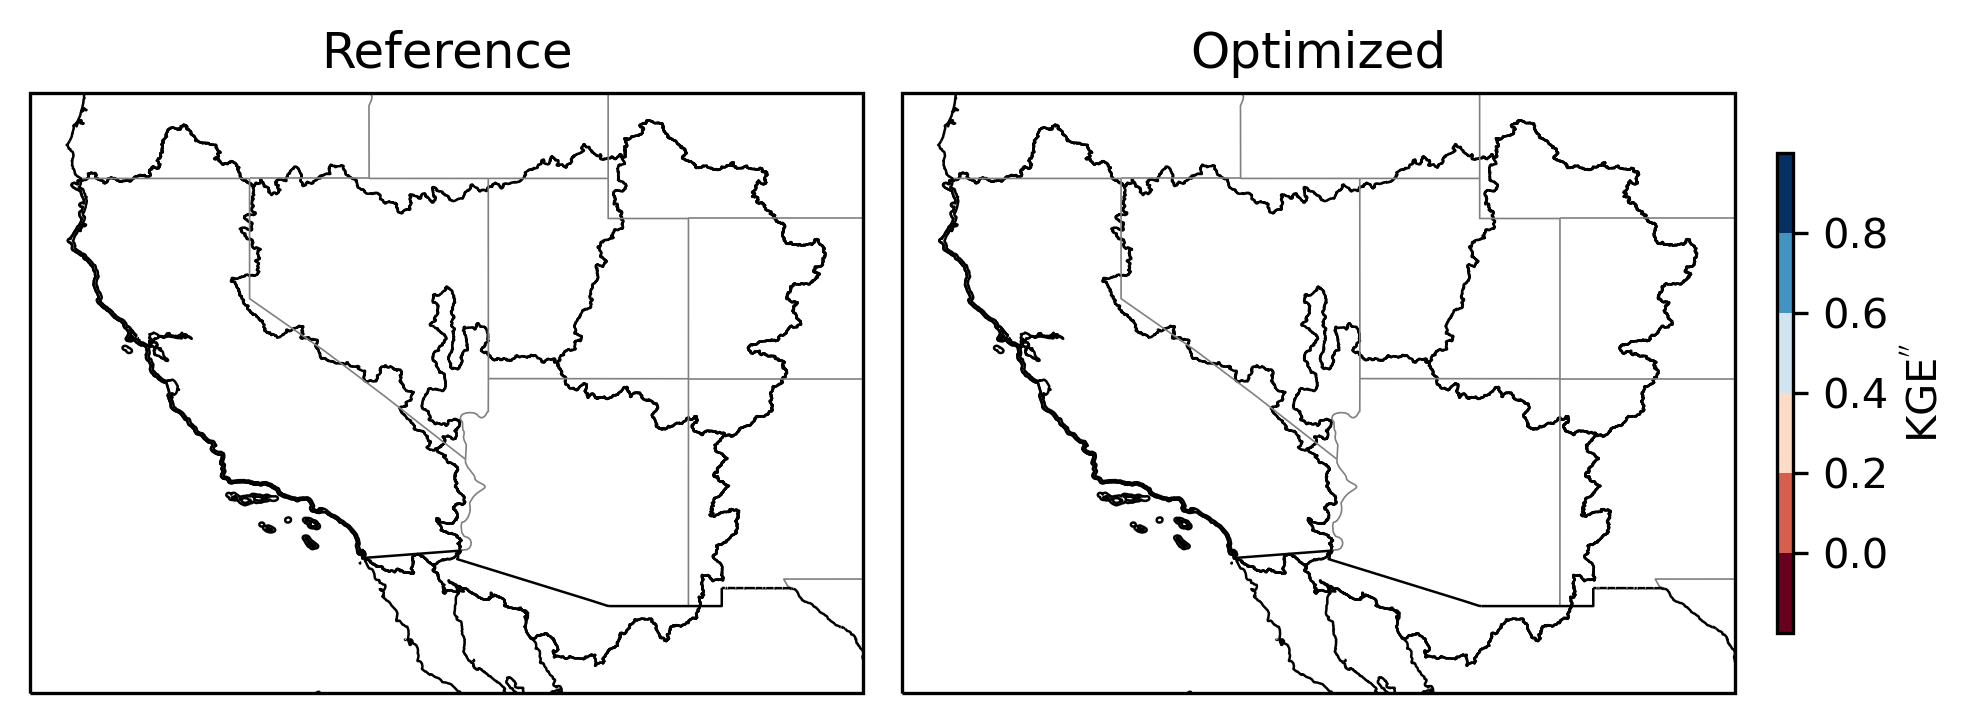

In [8]:
norm = matplotlib.colors.BoundaryNorm(boundaries=cbar_ticks[metric], ncolors=256, extend='both')
ticks = cbar_ticks[metric]
label = labels[metric]

fig = plt.figure(figsize=(7,8), dpi=300)

# MAP of KGE''
gs1 = gridspec.GridSpec(1,2)
gs1.update(left=0.,right=1.,top=1.,bottom=.75,wspace=0.,hspace=0.25)
titles = ['Reference', 'Optimized']
axes = []
states_provinces = cfeature.NaturalEarthFeature(category='cultural',
                                                name='admin_1_states_provinces_lines',
                                                scale='50m',
                                                facecolor='none')
for i,m in zip(range(2), ['ref','opt']):
    ax = plt.subplot(gs1[0,i],projection=ccrs.PlateCarree())
    ax.set_title(titles[i])
    axes += [ax]
    ax.add_feature(states_provinces, edgecolor='grey', lw=.4)
    ax.add_feature(cfeature.BORDERS, edgecolor='k', lw=.6)
    # ax.add_feature(cfeature.LAKES, edgecolor='grey', lw=.1)
    ax.add_feature(cfeature.COASTLINE, edgecolor='k', lw=.6)
    gdf_ucrb_crs.plot(ax=ax, lw=0.6, facecolor='None', edgecolor='k')
    gdf_lcrb_crs.plot(ax=ax, lw=0.6, facecolor='None', edgecolor='k')
    gdf_ca_crs.plot(ax=ax, lw=0.6, facecolor='None', edgecolor='k')
    gdf_sw_crs.plot(ax=ax, lw=0.6, facecolor='None', edgecolor='k')
    # ax.set_extent(extent)
    # gdf_geoms_union.plot(ax=ax, column=m, cmap=cmap, norm=norm, edgecolor='k', lw=0.1, zorder=-1)
    # if i==0:
        # gdf_ca_sel.plot(ax=ax, edgecolor='tab:green', facecolor='None',lw=.6)
        # gdf_ucrb_crs.plot(ax=ax, edgecolor='tab:green', facecolor='None',lw=.6)
        # ax.annotate('Northern Sierras', (.225,.925), xycoords='axes fraction', ha='left', color='tab:green', fontsize=10)
        # ax.annotate('Upper Colorado', (.695,.725), xycoords='axes fraction', ha='right', color='tab:green', fontsize=10)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cb = plt.colorbar(sm, ax=axes,location='right',aspect=30, shrink=.8, ticks=ticks, 
                  extendfrac='auto', extendrect=True, pad=0.02)
cb.set_label(label)

In [9]:
# Hydrographs

In [10]:
qmdl_ref_mon = qmdl_ref.resample(time='1M').mean()
qmdl_opt_mon = qmdl_opt.resample(time='1M').mean()

In [11]:
comids_ca = pd.read_csv('/glade/work/elkoukah/inputs/obs/CDEC_Stations_COMID.csv')
comids_ca = comids_ca.set_index('STA')
comids_ca = comids_ca.drop('CLD')

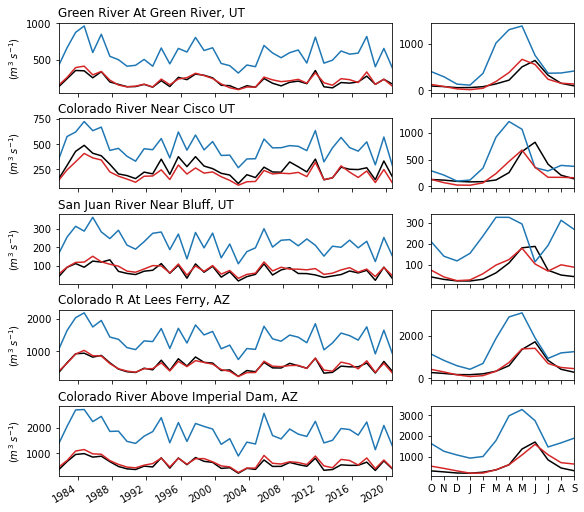

In [12]:
cr_sel_stations = {
    "09315000": "Green River At Green River, UT",
    "09180500": "Colorado River Near Cisco UT",
    "09379500": "San Juan River Near Bluff, UT",
    "09380000": "Colorado R At Lees Ferry, AZ",
    "09429490": "Colorado River Above Imperial Dam, AZ",
}
months = np.arange(12)
idx = np.append(months[9:], months[:9])

qobs_sel = qobs[list(cr_sel_stations.keys())]
qmdl_ref_sel = qmdl_ref_mon[list(cr_sel_stations.keys())]
qmdl_opt_sel = qmdl_opt_mon[list(cr_sel_stations.keys())]
qmdl_ref_sel["time"] = qobs_sel.time
qmdl_opt_sel["time"] = qobs_sel.time

xx_ann = qobs_sel.resample(time='A-SEP').mean()
yyref_ann = qmdl_ref_mon.resample(time='A-SEP').mean()
yyopt_ann = qmdl_opt_mon.resample(time='A-SEP').mean()

xx_annc = qobs_sel.groupby("time.month").mean()
yyref_annc = qmdl_ref_mon.groupby("time.month").mean()
yyopt_annc = qmdl_opt_mon.groupby("time.month").mean()

sel_sts = list(cr_sel_stations.keys())
fig, axes = plt.subplots(len(sel_sts), 2, sharex="col", constrained_layout=True,
                         sharey=False, figsize=(8, 7), gridspec_kw={'width_ratios':[.7,.3]})
# plt.subplots_adjust(wspace=0.05)
for i in range(len(sel_sts)):
    ax1 = axes[i, 1]
    ax1.plot(xx_annc[sel_sts[i]].data[idx], c="k", label="Observed (Reclamation)")
    ax1.plot(yyref_annc[sel_sts[i]].data[idx], label="Simulated (refCLM-CaMa-Flood)")
    ax1.plot(yyopt_annc[sel_sts[i]].data[idx], c='tab:red', label="Simulated (optCLM-CaMa-Flood)")
    ax1.set_xticks(range(12))
    ax1.set_xticklabels(["O","N","D","J","F","M","A","M","J","J","A","S",])

    ax2 = axes[i, 0]
    xx_ann[sel_sts[i]].plot(ax=ax2, c="k")
    yyref_ann[sel_sts[i]].plot(ax=ax2)
    yyopt_ann[sel_sts[i]].plot(ax=ax2, c='tab:red')
    ax2.set_ylabel(None)
    ax2.set_xlabel(None)
    # ax2.annotate(cr_sel_stations[sel_sts[i]], (0.015, 1), xycoords="axes fraction")
    ax2.set_ylabel("($m^3\;s^{-1}$)")
    ax2.set_title(cr_sel_stations[sel_sts[i]], loc='left')
for ax in axes.ravel():
    ax.margins(x=0)

fig.align_ylabels(axes[:, 0])
# fig.savefig("./figs/nat_opt_ref_cr.png", dpi=300, bbox_inches="tight",)

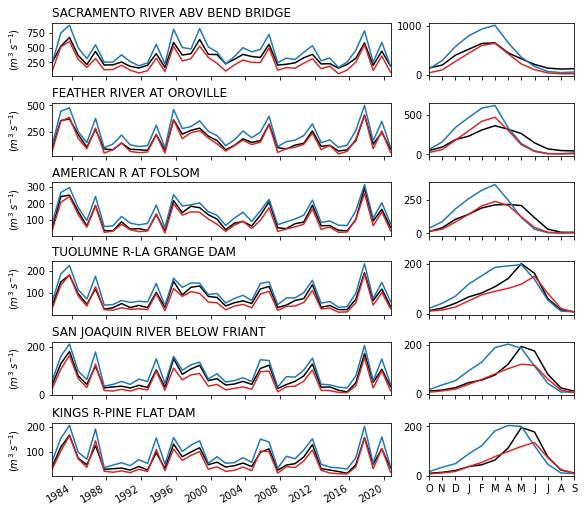

In [13]:
sel_sts = ['SBB', 'FTO', 'AMF', # Sacremento
           'TLG', 'SJF', 'KGF'] #San Joaquin
ca_sel_stations = comids_ca.loc[sel_sts]['Station Name'].to_dict()
months = np.arange(12)
idx = np.append(months[9:], months[:9])

qobs_sel = qobs[sel_sts]
qmdl_ref_sel = qmdl_ref_mon[sel_sts]
qmdl_opt_sel = qmdl_opt_mon[sel_sts]
qmdl_ref_sel["time"] = qobs_sel.time
qmdl_opt_sel["time"] = qobs_sel.time

xx_ann = qobs_sel.resample(time='A-SEP').mean()
yyref_ann = qmdl_ref_mon.resample(time='A-SEP').mean()
yyopt_ann = qmdl_opt_mon.resample(time='A-SEP').mean()

xx_annc = qobs_sel.groupby("time.month").mean()
yyref_annc = qmdl_ref_mon.groupby("time.month").mean()
yyopt_annc = qmdl_opt_mon.groupby("time.month").mean()

fig, axes = plt.subplots(len(sel_sts), 2, sharex="col", constrained_layout=True,
                         sharey=False, figsize=(8, 7), gridspec_kw={'width_ratios':[.7,.3]})
# plt.subplots_adjust(wspace=0.05)
for i in range(len(sel_sts)):
    ax1 = axes[i, 1]
    ax1.plot(xx_annc[sel_sts[i]].data[idx], c="k", label="Observed (Reclamation)")
    ax1.plot(yyref_annc[sel_sts[i]].data[idx], label="Simulated (refCLM-CaMa-Flood)")
    ax1.plot(yyopt_annc[sel_sts[i]].data[idx], c='tab:red', label="Simulated (optCLM-CaMa-Flood)")
    ax1.set_xticks(range(12))
    ax1.set_xticklabels(["O","N","D","J","F","M","A","M","J","J","A","S",])

    ax2 = axes[i, 0]
    xx_ann[sel_sts[i]].plot(ax=ax2, c="k")
    yyref_ann[sel_sts[i]].plot(ax=ax2)
    yyopt_ann[sel_sts[i]].plot(ax=ax2, c='tab:red')
    ax2.set_ylabel(None)
    ax2.set_xlabel(None)
    ax2.set_ylabel("($m^3\;s^{-1}$)")
    ax2.set_title(ca_sel_stations[sel_sts[i]], loc='left')
for ax in axes.ravel():
    ax.margins(x=0)

fig.align_ylabels(axes[:, 0])
# fig.savefig("./figs/nat_opt_ref_ca.png", dpi=300, bbox_inches="tight",)

In [14]:
# Sensitivity

In [15]:
tdelta = slice('1980-10-01', '2020-09-30')

dict_sens_plot = {}
dict_q_plot = {}
# UCRB
ppto, qo = dict_sens_obs['ucrb']
ppto = ppto/ppto.time.dt.days_in_month
ppto = ppto.sel(time=tdelta).resample(time='A-SEP').mean()
dppto = (ppto-ppto.mean())/ppto.mean() * 100
qo = qo.sel(time=tdelta).resample(time='A-SEP').mean()
dqo = (qo-qo.mean())/qo.mean() * 100
pptm = dict_precip_mdl['ucrb'].sel(time=tdelta).resample(time='A-SEP').mean()
dpptm = (pptm-pptm.mean())/pptm.mean() * 100
qm1 = qmdl_opt['09380000'].sel(time=tdelta).resample(time='A-SEP').mean()
qm0 = qmdl_ref['09380000'].sel(time=tdelta).resample(time='A-SEP').mean()
dqm1 = (qm1-qm1.mean())/qm1.mean() * 100
dqm0 = (qm0-qm0.mean())/qm0.mean() * 100
dict_sens_plot['ucrb'] = {'obs':(dppto, dqo), 'mdl_opt':(dpptm, dqm1), 'mdl_ref':(dpptm, dqm0)}
#
_, qo = dict_sens_obs['ucrb']
qo = qo.sel(time=tdelta)
qm0 = qmdl_ref_mon['09380000'].sel(time=tdelta)
qm1 = qmdl_opt_mon['09380000'].sel(time=tdelta)
qm0["time"] = qo.time
qm1["time"] = qo.time
dict_q_plot['ucrb'] = {'obs':qo, 'mdl_opt':qm1, 'mdl_ref':qm0}

# NS
ppto, qo = dict_sens_obs['ns']
ppto = ppto/ppto.time.dt.days_in_month
ppto = ppto.sel(time=tdelta).resample(time='A-SEP').mean()
dppto = (ppto-ppto.mean())/ppto.mean() * 100
qo = qo.sel(time=tdelta).resample(time='A-SEP').mean()
dqo = (qo-qo.mean())/qo.mean() * 100
pptm = dict_precip_mdl['ns'].sel(time=tdelta).resample(time='A-SEP').mean()
dpptm = (pptm-pptm.mean())/pptm.mean() * 100
qm1 = (qmdl_opt['AMF']+qmdl_opt['SBB']+qmdl_opt['YRS']+qmdl_opt['FTO']).sel(time=tdelta).resample(time='A-SEP').mean()
qm0 = (qmdl_ref['AMF']+qmdl_ref['SBB']+qmdl_ref['YRS']+qmdl_ref['FTO']).sel(time=tdelta).resample(time='A-SEP').mean()
dqm1 = (qm1-qm1.mean())/qm1.mean() * 100
dqm0 = (qm0-qm0.mean())/qm0.mean() * 100
dict_sens_plot['ns'] = {'obs':(dppto, dqo), 'mdl_opt':(dpptm, dqm1), 'mdl_ref':(dpptm, dqm0)}
#
_, qo = dict_sens_obs['ns']
qo = qo.sel(time=tdelta)
qm1 = (qmdl_opt_mon['AMF']+qmdl_opt_mon['SBB']+qmdl_opt_mon['YRS']+qmdl_opt_mon['FTO']).sel(time=tdelta)
qm0 = (qmdl_ref_mon['AMF']+qmdl_ref_mon['SBB']+qmdl_ref_mon['YRS']+qmdl_ref_mon['FTO']).sel(time=tdelta)
qm0["time"] = qo.time
qm1["time"] = qo.time
dict_q_plot['ns'] = {'obs':qo, 'mdl_opt':qm1, 'mdl_ref':qm0}

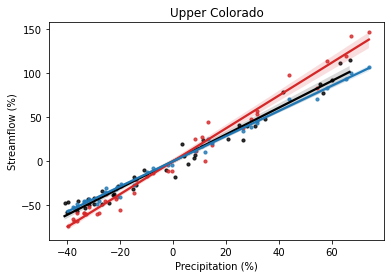

In [16]:
fig = plt.figure()
ax = plt.subplot(111)
data_dict = dict_sens_plot['ns']
sns.regplot(x=data_dict['obs'][0], y=data_dict['obs'][1], ax=ax, color='k', truncate=True, 
            scatter_kws={'s':10}, label='Observed');
sns.regplot(x=data_dict['mdl_opt'][0], y=data_dict['mdl_opt'][1], ax=ax, color='tab:red', truncate=True,
            scatter_kws={'s':10}, label='Optimized CLM5');
sns.regplot(x=data_dict['mdl_ref'][0], y=data_dict['mdl_ref'][1], ax=ax, color='tab:blue', truncate=True,
            scatter_kws={'s':10}, label='Reference CLM5');
ax.set_ylabel(r'Streamflow (%)')
ax.set_xlabel(r'Precipitation (%)')
ax.set_title('Upper Colorado')
ax.tick_params(which='minor',length=3);   # dont show minor ticks; only labels

In [17]:
# SFC

In [18]:
def plot_map_mean_fluxes(ax, da, levels, dpi, cmap, cbarlabel):
    cf = da.plot.contourf(ax=ax, levels=levels, cmap=cmap, add_colorbar=False)
    da.plot.contour(ax=ax, levels=levels, cmap=cmap, zorder=-9, add_colorbar=False)
    # gdf_ucrb_crs.plot(ax=ax, lw=0.6, facecolor='None', edgecolor='k')
    # gdf_lcrb_crs.plot(ax=ax, lw=0.6, facecolor='None', edgecolor='k')
    # gdf_ca_crs.plot(ax=ax, lw=0.6, facecolor='None', edgecolor='k')
    gdf_sw_crs.plot(ax=ax, lw=0.6, facecolor='None', edgecolor='k')
    states_provinces = cfeature.NaturalEarthFeature(category='cultural',
                                                    name='admin_1_states_provinces_lines',
                                                    scale='50m',
                                                    facecolor='none')
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.COASTLINE, zorder=-9)
    ax.add_feature(states_provinces, edgecolor='gray', lw=.4)
    return cf

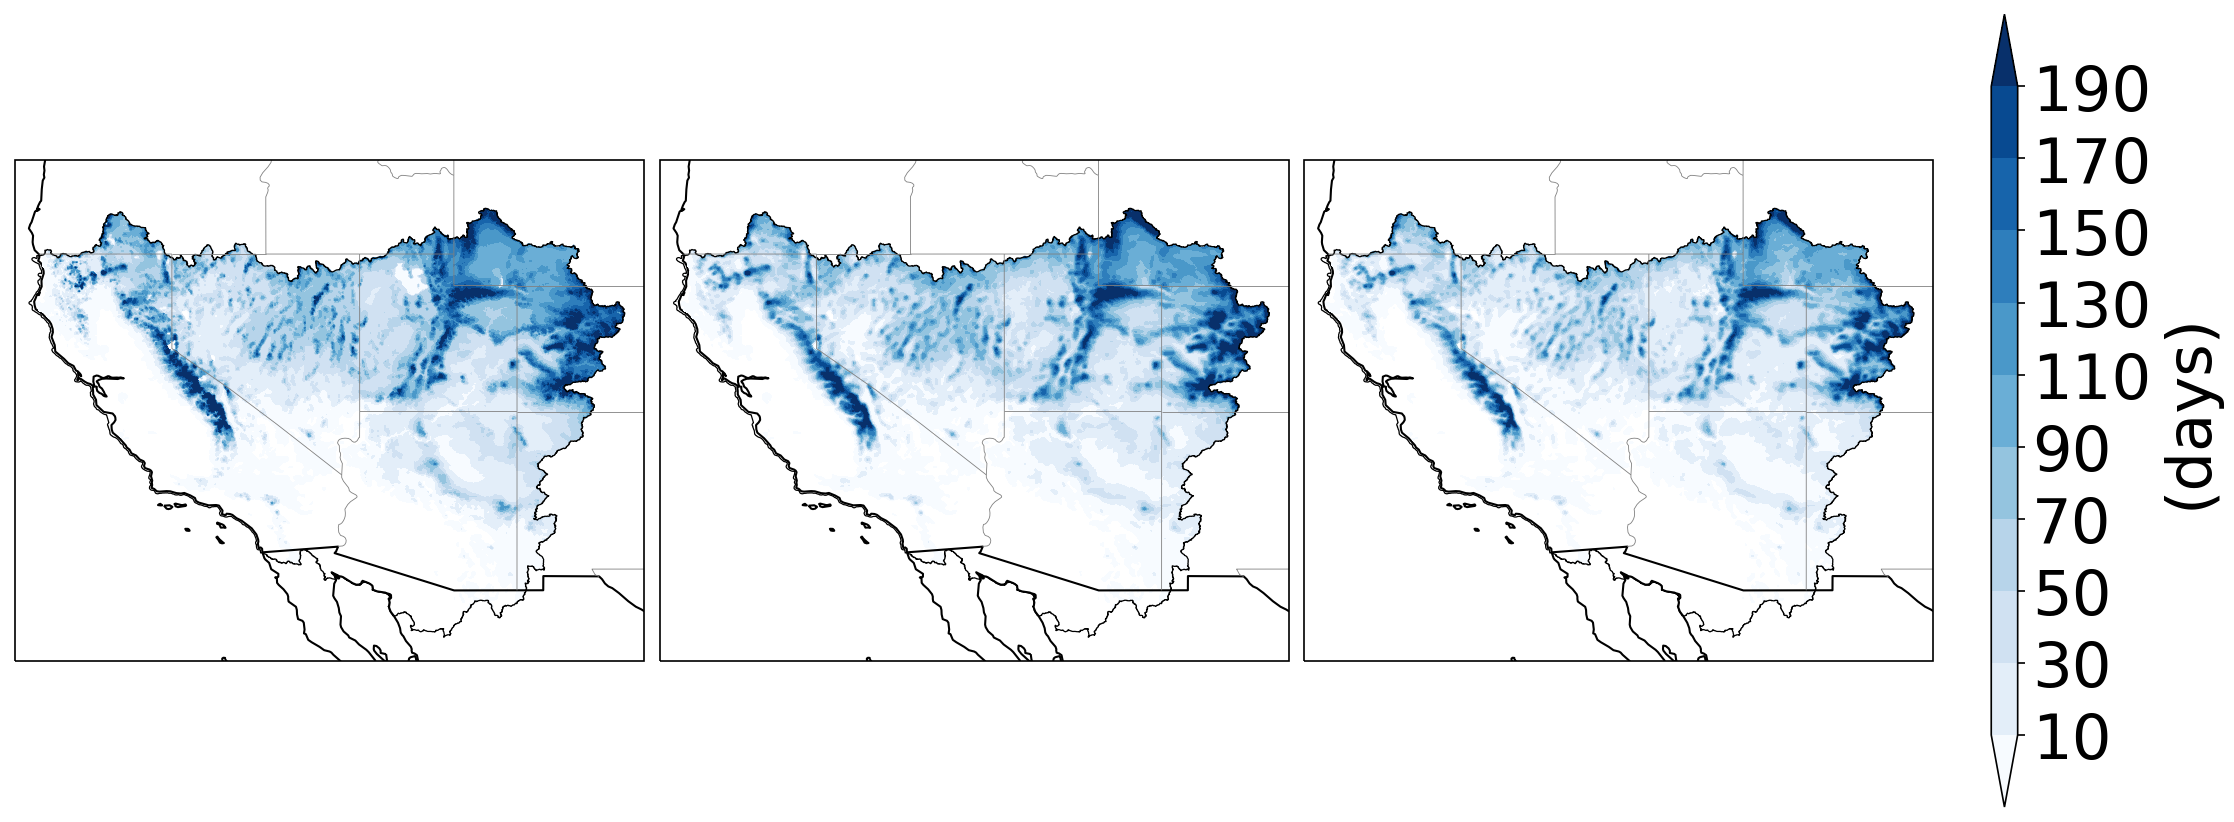

In [19]:
dpi = 150
levels = np.arange(10, 200, 20)
fig = plt.figure(figsize=(20,10), dpi=dpi)
ax = plt.subplot(131, projection=ccrs.PlateCarree())
da = dict_sfc['obs']
da1 = dict_sfc['ref']
cf = plot_map_mean_fluxes(ax, da.where(da1>0), levels, 150, 'Blues', 'days')

ax = plt.subplot(132, projection=ccrs.PlateCarree())
da = dict_sfc['ref']
cf = plot_map_mean_fluxes(ax, da.where(da>0), levels, 150, 'Blues', 'days')

ax = plt.subplot(133, projection=ccrs.PlateCarree())
da = dict_sfc['opt']
cf = plot_map_mean_fluxes(ax, da.where(da>0), levels, 150, 'Blues', 'days')

plt.subplots_adjust(wspace=0.025)
cbar = fig.colorbar(cf, ax=fig.axes, aspect=30, extendfrac='auto', shrink=.7, pad=0.025)
cbar.ax.tick_params(labelsize=30)
cbar.set_label(fontsize=30, label='(days)')

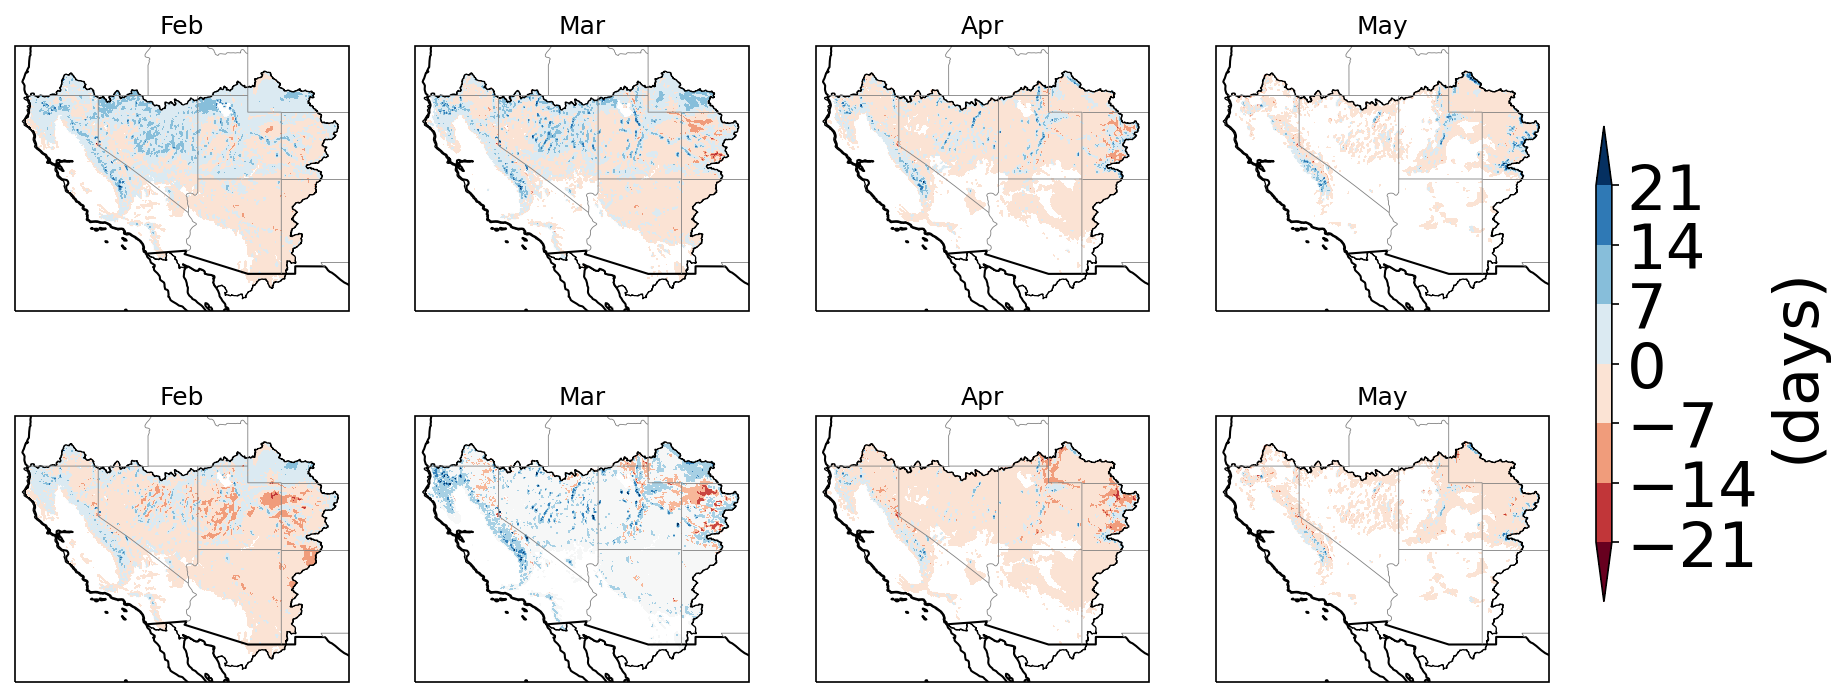

In [20]:
levels = np.arange(-21, 21+1, 7)
# fig = plt.figure(figsize=(20,10), dpi=dpi)
fig, axes = plt.subplots(2, 4, figsize=(16,6), dpi=dpi,
                         subplot_kw=dict(projection=ccrs.PlateCarree()))
da0 = dict_sfc_mon['obs']
da1 = dict_sfc_mon['ref']
da2 = dict_sfc_mon['opt']
titles = ['Feb','Mar','Apr','May']
for i, m in zip(range(4), range(1, 5)):
    da = da1[m]-da0[m]
    ax = axes[0,i]
    cf = plot_map_mean_fluxes(ax, da.where(da0[m]>0), levels, 150, 'RdBu', 'days')
    ax.set_title(titles[i])
    
    da = da2[m]-da0[m]
    ax = axes[1,i]
    cf = plot_map_mean_fluxes(ax, da.where(da0[m]>0), levels, 150, 'RdBu', 'days')
    ax.set_title(titles[i])
    
    # break
cbar = fig.colorbar(cf, ax=fig.axes, aspect=30, extendfrac='auto', shrink=.7, pad=0.025)
cbar.ax.tick_params(labelsize=30)
cbar.set_label(fontsize=30, label='(days)')

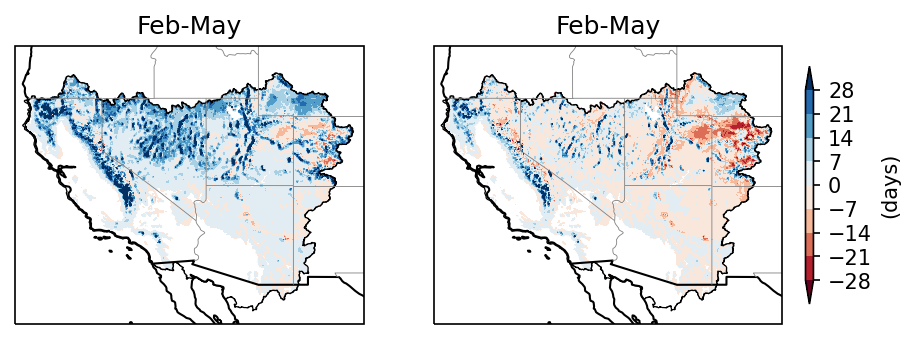

In [45]:
levels = np.arange(-28, 28+1, 7)
# fig = plt.figure(figsize=(20,10), dpi=dpi)
fig, axes = plt.subplots(1, 2, figsize=(8,3), dpi=dpi,
                         subplot_kw=dict(projection=ccrs.PlateCarree()))
m = [1,2,3,4]
da0 = dict_sfc_mon['obs'][m].sum('month')
da1 = dict_sfc_mon['ref'][m].sum('month')
da2 = dict_sfc_mon['opt'][m].sum('month')
da = da1-da0
ax = axes[0]
cf = plot_map_mean_fluxes(ax, da.where(da0>0), levels, 150, 'RdBu', 'days')
ax.set_title('Feb-May')

da = da2-da0
ax = axes[1]
cf = plot_map_mean_fluxes(ax, da.where(da0>0), levels, 150, 'RdBu', 'days')
ax.set_title('Feb-May')

cbar = fig.colorbar(cf, ax=fig.axes, aspect=30, extendfrac='auto', shrink=.7, pad=0.025)
cbar.set_label(label='(days)')

In [21]:
dict_sfc_metrics = pickle.load(open('out/sfc_0p5_metrics.pkl', 'rb'))

In [22]:
spatial_metrics = dict_sfc_metrics['spatial']
temporal_metrics = dict_sfc_metrics['temporal']
gdf_scf = dict_sfc_metrics['gdf']

In [23]:
metric = 'mkge'
idx = temporal_metrics.loc[:, ('opt','fsno')]>=0.05
gdf_scf.loc[:, 'ref'] = temporal_metrics.loc[:, ('ref', metric)]
gdf_scf.loc[:, 'opt'] = temporal_metrics.loc[:, ('opt', metric)]
gdf_sfc_t = gdf_scf.loc[idx]

gdf_scf.loc[:, 'ref'] = spatial_metrics.loc[:, ('ref', metric)]
gdf_scf.loc[:, 'opt'] = spatial_metrics.loc[:, ('opt', metric)]
gdf_sfc_sp = gdf_scf.loc[idx]

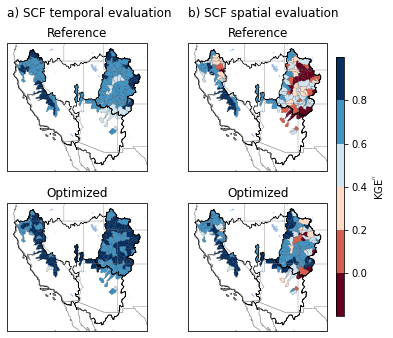

In [24]:
fig = plt.figure(figsize=(11,5))
gs1 = gridspec.GridSpec(2,2)
gs1.update(left=0.1,right=0.625,top=0.9,bottom=0.1,wspace=0.1,hspace=0.25)

titles = ['a) SCF temporal evaluation', 'b) SCF spatial evaluation']
subtitles = ['Reference', 'Optimized']
gs1_axes = []
for i, sim in enumerate(['ref','opt']):
    for j, gdfj in enumerate([gdf_sfc_t, gdf_sfc_sp]):
        ax = plt.subplot(gs1[i,j],projection=ccrs.PlateCarree())
        gs1_axes.append(ax)
        ax.add_feature(states_provinces, edgecolor='gray', lw=.4)
        ax.add_feature(cfeature.BORDERS, edgecolor='gray', lw=.6)
        ax.add_feature(cfeature.LAKES, edgecolor='None', lw=.1)
        ax.add_feature(cfeature.COASTLINE, edgecolor='gray', lw=.6)
        gdf_ucrb_crs.plot(ax=ax, lw=0.6, facecolor='None', edgecolor='k')
        gdf_lcrb_crs.plot(ax=ax, lw=0.6, facecolor='None', edgecolor='k')
        gdf_ca_crs.plot(ax=ax, lw=0.6, facecolor='None', edgecolor='k')
        gdf_sw_crs.plot(ax=ax, lw=0.6, facecolor='None', edgecolor='k')
        # ax.set_extent(extent)
        ax.set_title(subtitles[i])
        fc = gdfj.plot(ax=ax, column=sim, cmap=cmap, norm=norm, edgecolor='k', lw=.1, zorder=-1)
        # break
    # break
gs1_axes[0].annotate(titles[0], (0,1.2), xycoords='axes fraction', fontsize=12)
gs1_axes[1].annotate(titles[1], (0,1.2), xycoords='axes fraction', fontsize=12)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cb = plt.colorbar(sm,ax=gs1_axes,location='right',aspect=30, shrink=.9, ticks=ticks, extendfrac='auto', extendrect=True, pad=0.02)
cb.set_label(label)

In [25]:
tdelta = slice('2004-10-01', '2019-09-01')
obs_swe = dict_swe['obs']
obs_swe['time'] = obs_swe.time.astype('datetime64[ns]')
ma = (obs_swe.time.dt.day==29)&(obs_swe.time.dt.month==2)
obs_swe = obs_swe.sel(time=~ma)

opt_swe = dict_swe['opt']['H2OSNO']
opt_swe['time'] = opt_swe.time.astype('datetime64[ns]')
opt_swe = opt_swe.sel(time=obs_swe.time)
opt_swe = opt_swe.where(~obs_swe.isnull())

ref_swe = dict_swe['ref']['H2OSNO']
ref_swe['time'] = ref_swe.time.astype('datetime64[ns]')
ref_swe = ref_swe.sel(time=obs_swe.time)
ref_swe = ref_swe.where(~obs_swe.isnull())

swe_plot = {'obs':obs_swe, 'ref':ref_swe, 'opt':opt_swe, }

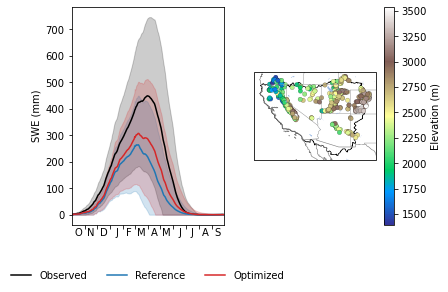

In [26]:
fig = plt.figure()
states_provinces = cfeature.NaturalEarthFeature(category='cultural',
                                                name='admin_1_states_provinces_lines',
                                                scale='50m',
                                                facecolor='none')
ax = plt.subplot(122, projection=ccrs.PlateCarree())
ax.add_feature(states_provinces, edgecolor='gray', lw=.4)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', lw=.6)
ax.add_feature(cfeature.LAKES, edgecolor='None', lw=.1)
ax.add_feature(cfeature.COASTLINE, edgecolor='gray', lw=.6)
gdf_sw_crs.plot(ax=ax, lw=0.6, facecolor='None', edgecolor='k')

yy = swe_stations_sel['latitude'].data[0]
xx = swe_stations_sel['longitude'].data[0]
zz = swe_stations_sel['elevation'].data[0]
sc = ax.scatter(xx, yy, c=zz, cmap='terrain', edgecolor='k', lw=.15, s=20)
cb2 = plt.colorbar(sc, ax=ax)
cb2.set_label('Elevation (m)')

ax = plt.subplot(121)
days = np.arange(365)
idx = np.append(days[273:],days[:273])
monthlength = np.array([31,30,31, 31,28,31,30,31,30,31,31,30])
legend = ['Observed', 'Reference', 'Optimized']
colors = ('k', 'tab:blue', 'tab:red')
for i, m in enumerate(('obs', 'ref', 'opt')): 
    da = swe_plot[m]
    swe_doy = da.groupby('time.dayofyear').mean()
    mu = swe_doy.mean('site')
    sigma = swe_doy.std('site')
    swe_min = swe_doy.min('site')
    swe_max = swe_doy.max('site')
    
    ax.plot(mu.data[idx], label=legend[i], color=colors[i], markersize=2)
    ax.fill_between(days, np.max(np.stack([mu-sigma, np.zeros((mu.size,))]), axis=0)[idx], (mu+sigma)[idx], color=colors[i], alpha=0.2)
    # ax.fill_between(days, swe_min.data[idx], swe_max[idx], color='k', alpha=0.2)
    ax.set_xticks(np.cumsum(monthlength))
    ax.set_xticklabels('')
    ax.set_xticks((monthlength*1.0/2.)+np.cumsum(np.append(0,monthlength)[0:12]), minor=True)
    ax.set_xticklabels(['O','N','D', 'J','F','M','A','M','J','J','A','S',], minor=True);
    ax.tick_params('x',which='minor',length=0)
    ax.margins(x=0)
ax.set_ylabel('SWE (mm)')
ax.legend(ncol=3, loc='lower center', bbox_to_anchor=(.5,-0.3), frameon=False)

In [74]:
x = obs_swe.groupby('time.dayofyear').max().max('dayofyear')
x = x.where(x>0)
y0 = ref_swe.groupby('time.dayofyear').max().max('dayofyear')
y1 = opt_swe.groupby('time.dayofyear').max().max('dayofyear')
print(float(((y0-x)/x).mean()))
print(float(((y1-x)/x).mean()))

-0.23903006315231323
-0.1646685153245926


In [75]:
# TWS

In [27]:
tdelta_eval = slice('2002-04', '2020-09')
tws_plot = {}
for i, case in enumerate(('CR','CA')):
    da_jpl, da_csr, da_gsfc, opt_tws, ref_tws = dict_tws[case]
    opt_tws = opt_tws.sel(time=tdelta_eval)
    opt_tws['time'] = opt_tws.time.astype('datetime64[m]')
    ref_tws = ref_tws.sel(time=tdelta_eval)
    ref_tws['time'] = ref_tws.time.astype('datetime64[m]')
    da_jpl = da_jpl.resample(time='1M').mean().sel(time=tdelta_eval)
    da_csr = da_csr.resample(time='1M').mean().sel(time=tdelta_eval)
    da_gsfc = da_gsfc.resample(time='1M').mean().sel(time=tdelta_eval)
    da_jpl['time'] = ref_tws.time
    da_csr['time'] = ref_tws.time
    da_gsfc['time'] = ref_tws.time
    da_grace = xr.concat([da_jpl,da_csr,da_gsfc], dim='inst')
    time = da_grace.time.astype('datetime64[m]').data
    tws_plot[case] = (ref_tws,opt_tws,da_jpl,da_csr,da_gsfc,time,da_grace)

In [28]:
def trend_line(da):
    yhat = da.dropna('time')
    coef = np.polyfit(np.arange(yhat.size),yhat,1)
    poly1d_fn = np.poly1d(coef)
    return poly1d_fn(np.arange(da.size))

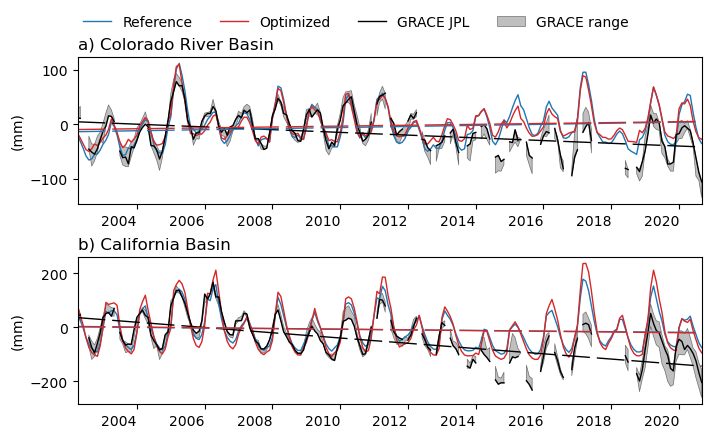

In [29]:
fig, axes = plt.subplots(2,1, figsize=(7,4), dpi=100, sharex=False, layout="constrained",)
months = np.arange(12)
idx = np.append(months[9:],months[:9])

for i, case in enumerate(('CR','CA')):
    ax = axes[i]
    yy_base,yy,da_jpl,da_csr,da_gsfc,time,da_grace = tws_plot[case]
    # ax.axhline(0, c='k', lw=1, ls='--')
    yy_base.plot(ax=ax,lw=1, label='Reference')
    g = yy.plot(ax=ax,lw=1, c='tab:red', label='Optimized')
    da_jpl.plot(ax=ax,lw=1, c='k', label='GRACE JPL')
    # da_csr.plot(c='grey', label='CSR')
    # da_gsfc.plot(c='lightgrey', label='GSFC')
    ax.fill_between(time, da_grace.min('inst'), da_grace.max('inst'), 
                     color='grey',edgecolor='k', lw=.5,alpha=.5, label='GRACE range')
    
    ax.plot(da_jpl.time, trend_line(da_jpl), '--k', dashes=(20, 5), lw=1)
    ax.plot(yy_base.time, trend_line(yy_base), c='tab:blue', ls='--', dashes=(20, 5), lw=1)
    ax.plot(yy.time, trend_line(yy), c='tab:red', ls='--', dashes=(20, 5), lw=1)
    
    ax.set_ylabel('(mm)')
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=0)
    # ax.set_xticklabels(, rotation=0, ha='center')
    ax.margins(x=0, y=0.05)
    
    if case=='CR':
        ax.set_title('a) Colorado River Basin', loc='left')
    else:
        ax.set_title('b) California Basin', loc='left')
h,l = ax.get_legend_handles_labels()
fig.legend(h,l, loc='upper center', ncol=4, bbox_to_anchor=(.5,1.075), frameon=False)

In [30]:
# combine all

In [31]:
# gridspec bare

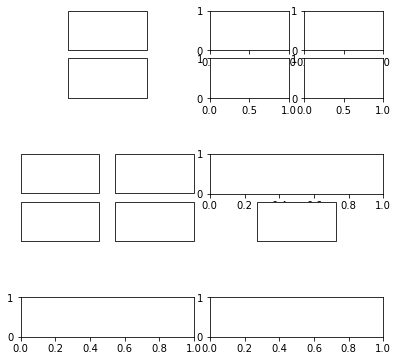

In [81]:
fig = plt.figure(figsize=(6.5,6))
gspec = gridspec.GridSpec(
    ncols=4, nrows=7, figure=fig, height_ratios=[1, 1, 1, 1, 1, 1, 1]
)
# streamflow
ax = plt.subplot(gspec[0, :2],projection=ccrs.PlateCarree())
ax = plt.subplot(gspec[1, :2],projection=ccrs.PlateCarree())
# hydrographs
ax = plt.subplot(gspec[0, 2])
ax = plt.subplot(gspec[1, 2])
# sensitivity
ax = plt.subplot(gspec[0, 3])
ax = plt.subplot(gspec[1, 3])
# SCF
ax = plt.subplot(gspec[3, 0],projection=ccrs.PlateCarree())
ax = plt.subplot(gspec[3, 1],projection=ccrs.PlateCarree())
ax = plt.subplot(gspec[4, 0],projection=ccrs.PlateCarree())
ax = plt.subplot(gspec[4, 1],projection=ccrs.PlateCarree())
# SWE
ax = plt.subplot(gspec[3, 2:])
ax = plt.subplot(gspec[4, 2:],projection=ccrs.PlateCarree())
# TWS
ax = plt.subplot(gspec[6, :2])
ax = plt.subplot(gspec[6, 2:])

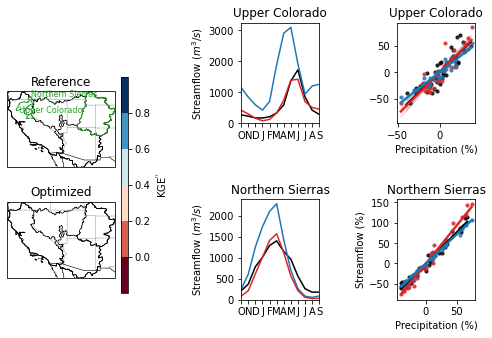

In [105]:
states_provinces = cfeature.NaturalEarthFeature(category='cultural',
                                                name='admin_1_states_provinces_lines',
                                                scale='50m',
                                                facecolor='none')
extent = (-124.6, -105.6, 30.02, 43.46)

fig = plt.figure(figsize=(6.5,15))
gspec = gridspec.GridSpec(
    nrows=1, ncols=3, figure=fig, hspace=.05, wspace=.05,
    height_ratios=[1, .25], 
    width_ratios=[1, 1, .1],
    left=0.,right=1.,top=.95,bottom=.75
)
# streamflow
ax1 = plt.subplot(gspec[0, 0],projection=ccrs.PlateCarree())
ax2 = plt.subplot(gspec[0, 1],projection=ccrs.PlateCarree())
titles = ['Reference', 'Optimized']
axes = []
for i,m,ax in zip(range(2), ['ref','opt'], [ax1, ax2]):
    ax.set_title(titles[i])
    axes += [ax]
    ax.add_feature(states_provinces, edgecolor='grey', lw=.4)
    ax.add_feature(cfeature.BORDERS, edgecolor='k', lw=.6)
    ax.add_feature(cfeature.COASTLINE, edgecolor='k', lw=.6)
    gdf_ucrb_crs.plot(ax=ax, lw=0.6, facecolor='None', edgecolor='k')
    gdf_lcrb_crs.plot(ax=ax, lw=0.6, facecolor='None', edgecolor='k')
    gdf_ca_crs.plot(ax=ax, lw=0.6, facecolor='None', edgecolor='k')
    gdf_sw_crs.plot(ax=ax, lw=0.6, facecolor='None', edgecolor='k')
    ax.set_extent(extent)
    # gdf_geoms_union.plot(ax=ax, column=m, cmap=cmap, norm=norm, edgecolor='k', lw=0.1, zorder=-1)
    if i==0:
        gdf_ca_sel.plot(ax=ax, edgecolor='tab:green', facecolor='None',lw=.6)
        gdf_ucrb_crs.plot(ax=ax, edgecolor='tab:green', facecolor='None',lw=.6)
        ax.annotate('Northern Sierras', (.225,.925), xycoords='axes fraction', ha='left', color='tab:green', fontsize=8)
        ax.annotate('Upper Colorado', (.695,.725), xycoords='axes fraction', ha='right', color='tab:green', fontsize=8)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cax = plt.subplot(gspec[:2, 1], aspect=30)
cb = plt.colorbar(sm, cax=cax, ticks=ticks, extendfrac='auto', extendrect=True)
# cb = plt.colorbar(sm, ax=axes,location='right',aspect=30, shrink=.8, ticks=ticks, 
                  # extendfrac='auto', extendrect=True, pad=0.05)
cb.set_label(label)


gspec = gridspec.GridSpec(
    nrows=3, ncols=2, figure=fig, hspace=1., wspace=1.,
    left=.5,right=1.,top=1.,bottom=.65,
    height_ratios=[1, 1, .25],
)
# hydrographs
ax = plt.subplot(gspec[0, 0])
qdict = dict_q_plot['ucrb']
xx_annc = qdict['obs'].groupby("time.month").mean()
yyref_annc = qdict['mdl_ref'].groupby("time.month").mean()
yyopt_annc = qdict['mdl_opt'].groupby("time.month").mean()
months = np.arange(12)
idx = np.append(months[9:], months[:9])
ax.plot(xx_annc.data[idx], c="k", label="Observed")
ax.plot(yyref_annc.data[idx], label="Reference")
ax.plot(yyopt_annc.data[idx], c='tab:red', label="Optimized")
ax.set_xticks(range(12))
ax.set_xticklabels(["O","N","D","J","F","M","A","M","J","J","A","S",])
ax.margins(x=0)
ax.set_ylim(0)
ax.set_ylabel('Streamflow ($m^3/s$)')
ax.set_title('Upper Colorado')
#
ax = plt.subplot(gspec[1, 0])
qdict = dict_q_plot['ns']
xx_annc = qdict['obs'].groupby("time.month").mean()
yyref_annc = qdict['mdl_ref'].groupby("time.month").mean()
yyopt_annc = qdict['mdl_opt'].groupby("time.month").mean()
months = np.arange(12)
idx = np.append(months[9:], months[:9])
ax.plot(xx_annc.data[idx], c="k", label="Observed")
ax.plot(yyref_annc.data[idx], label="Reference")
ax.plot(yyopt_annc.data[idx], c='tab:red', label="Optimized")
ax.set_xticks(range(12))
ax.set_xticklabels(["O","N","D","J","F","M","A","M","J","J","A","S",])
ax.margins(x=0)
ax.set_ylim(0)
ax.set_ylabel('Streamflow ($m^3/s$)')
ax.set_title('Northern Sierras')
# sensitivity
ax = plt.subplot(gspec[0, 1])
data_dict = dict_sens_plot['ucrb']
sns.regplot(x=data_dict['obs'][0], y=data_dict['obs'][1], ax=ax, color='k', truncate=True, 
            scatter_kws={'s':10}, label='Observed');
sns.regplot(x=data_dict['mdl_opt'][0], y=data_dict['mdl_opt'][1], ax=ax, color='tab:red', truncate=True,
            scatter_kws={'s':10}, label='Optimized');
sns.regplot(x=data_dict['mdl_ref'][0], y=data_dict['mdl_ref'][1], ax=ax, color='tab:blue', truncate=True,
            scatter_kws={'s':10}, label='Reference');
ax.set_ylabel('')
ax.set_xlabel(r'Precipitation (%)')
ax.set_title('Upper Colorado')
ax.tick_params(which='minor',length=3);
#
ax = plt.subplot(gspec[1, 1])
data_dict = dict_sens_plot['ns']
sns.regplot(x=data_dict['obs'][0], y=data_dict['obs'][1], ax=ax, color='k', truncate=True, 
            scatter_kws={'s':10}, label='Observed');
sns.regplot(x=data_dict['mdl_opt'][0], y=data_dict['mdl_opt'][1], ax=ax, color='tab:red', truncate=True,
            scatter_kws={'s':10}, label='Optimized');
sns.regplot(x=data_dict['mdl_ref'][0], y=data_dict['mdl_ref'][1], ax=ax, color='tab:blue', truncate=True,
            scatter_kws={'s':10}, label='Reference');
ax.set_ylabel(r'Streamflow (%)')
ax.set_xlabel(r'Precipitation (%)')
ax.set_title('Northern Sierras')
ax.tick_params(which='minor',length=3);
# ax.annotate('Streamflow (%)', (-.35,1.45), xycoords='axes fraction', rotation=90, ha='center', va='center')

# # SCF
# ax = plt.subplot(gspec[3, 0],projection=ccrs.PlateCarree())
# ax = plt.subplot(gspec[3, 1],projection=ccrs.PlateCarree())
# ax = plt.subplot(gspec[4, 0],projection=ccrs.PlateCarree())
# ax = plt.subplot(gspec[4, 1],projection=ccrs.PlateCarree())
# # SWE
# ax = plt.subplot(gspec[3, 2:])
# ax = plt.subplot(gspec[4, 2:],projection=ccrs.PlateCarree())
# # TWS
# ax = plt.subplot(gspec[6, :2])
# ax = plt.subplot(gspec[6, 2:])

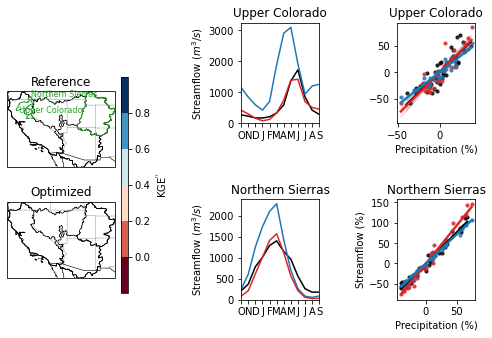

In [105]:
states_provinces = cfeature.NaturalEarthFeature(category='cultural',
                                                name='admin_1_states_provinces_lines',
                                                scale='50m',
                                                facecolor='none')
extent = (-124.6, -105.6, 30.02, 43.46)

fig = plt.figure(figsize=(6.5,15))
gspec = gridspec.GridSpec(
    nrows=2, ncols=3, figure=fig, hspace=.05, wspace=.05,
    height_ratios=[1, 1], 
    width_ratios=[1, .1, 1],
    left=0.,right=.5,top=.95,bottom=.75
)
# streamflow
ax1 = plt.subplot(gspec[0, 0],projection=ccrs.PlateCarree())
ax2 = plt.subplot(gspec[1, 0],projection=ccrs.PlateCarree())
titles = ['Reference', 'Optimized']
axes = []
for i,m,ax in zip(range(2), ['ref','opt'], [ax1, ax2]):
    ax.set_title(titles[i])
    axes += [ax]
    ax.add_feature(states_provinces, edgecolor='grey', lw=.4)
    ax.add_feature(cfeature.BORDERS, edgecolor='k', lw=.6)
    ax.add_feature(cfeature.COASTLINE, edgecolor='k', lw=.6)
    gdf_ucrb_crs.plot(ax=ax, lw=0.6, facecolor='None', edgecolor='k')
    gdf_lcrb_crs.plot(ax=ax, lw=0.6, facecolor='None', edgecolor='k')
    gdf_ca_crs.plot(ax=ax, lw=0.6, facecolor='None', edgecolor='k')
    gdf_sw_crs.plot(ax=ax, lw=0.6, facecolor='None', edgecolor='k')
    ax.set_extent(extent)
    # gdf_geoms_union.plot(ax=ax, column=m, cmap=cmap, norm=norm, edgecolor='k', lw=0.1, zorder=-1)
    if i==0:
        gdf_ca_sel.plot(ax=ax, edgecolor='tab:green', facecolor='None',lw=.6)
        gdf_ucrb_crs.plot(ax=ax, edgecolor='tab:green', facecolor='None',lw=.6)
        ax.annotate('Northern Sierras', (.225,.925), xycoords='axes fraction', ha='left', color='tab:green', fontsize=8)
        ax.annotate('Upper Colorado', (.695,.725), xycoords='axes fraction', ha='right', color='tab:green', fontsize=8)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cax = plt.subplot(gspec[:2, 1], aspect=30)
cb = plt.colorbar(sm, cax=cax, ticks=ticks, extendfrac='auto', extendrect=True)
# cb = plt.colorbar(sm, ax=axes,location='right',aspect=30, shrink=.8, ticks=ticks, 
                  # extendfrac='auto', extendrect=True, pad=0.05)
cb.set_label(label)


gspec = gridspec.GridSpec(
    nrows=3, ncols=2, figure=fig, hspace=1., wspace=1.,
    left=.5,right=1.,top=1.,bottom=.65,
    height_ratios=[1, 1, .25],
)
# hydrographs
ax = plt.subplot(gspec[0, 0])
qdict = dict_q_plot['ucrb']
xx_annc = qdict['obs'].groupby("time.month").mean()
yyref_annc = qdict['mdl_ref'].groupby("time.month").mean()
yyopt_annc = qdict['mdl_opt'].groupby("time.month").mean()
months = np.arange(12)
idx = np.append(months[9:], months[:9])
ax.plot(xx_annc.data[idx], c="k", label="Observed")
ax.plot(yyref_annc.data[idx], label="Reference")
ax.plot(yyopt_annc.data[idx], c='tab:red', label="Optimized")
ax.set_xticks(range(12))
ax.set_xticklabels(["O","N","D","J","F","M","A","M","J","J","A","S",])
ax.margins(x=0)
ax.set_ylim(0)
ax.set_ylabel('Streamflow ($m^3/s$)')
ax.set_title('Upper Colorado')
#
ax = plt.subplot(gspec[1, 0])
qdict = dict_q_plot['ns']
xx_annc = qdict['obs'].groupby("time.month").mean()
yyref_annc = qdict['mdl_ref'].groupby("time.month").mean()
yyopt_annc = qdict['mdl_opt'].groupby("time.month").mean()
months = np.arange(12)
idx = np.append(months[9:], months[:9])
ax.plot(xx_annc.data[idx], c="k", label="Observed")
ax.plot(yyref_annc.data[idx], label="Reference")
ax.plot(yyopt_annc.data[idx], c='tab:red', label="Optimized")
ax.set_xticks(range(12))
ax.set_xticklabels(["O","N","D","J","F","M","A","M","J","J","A","S",])
ax.margins(x=0)
ax.set_ylim(0)
ax.set_ylabel('Streamflow ($m^3/s$)')
ax.set_title('Northern Sierras')
# sensitivity
ax = plt.subplot(gspec[0, 1])
data_dict = dict_sens_plot['ucrb']
sns.regplot(x=data_dict['obs'][0], y=data_dict['obs'][1], ax=ax, color='k', truncate=True, 
            scatter_kws={'s':10}, label='Observed');
sns.regplot(x=data_dict['mdl_opt'][0], y=data_dict['mdl_opt'][1], ax=ax, color='tab:red', truncate=True,
            scatter_kws={'s':10}, label='Optimized');
sns.regplot(x=data_dict['mdl_ref'][0], y=data_dict['mdl_ref'][1], ax=ax, color='tab:blue', truncate=True,
            scatter_kws={'s':10}, label='Reference');
ax.set_ylabel('')
ax.set_xlabel(r'Precipitation (%)')
ax.set_title('Upper Colorado')
ax.tick_params(which='minor',length=3);
#
ax = plt.subplot(gspec[1, 1])
data_dict = dict_sens_plot['ns']
sns.regplot(x=data_dict['obs'][0], y=data_dict['obs'][1], ax=ax, color='k', truncate=True, 
            scatter_kws={'s':10}, label='Observed');
sns.regplot(x=data_dict['mdl_opt'][0], y=data_dict['mdl_opt'][1], ax=ax, color='tab:red', truncate=True,
            scatter_kws={'s':10}, label='Optimized');
sns.regplot(x=data_dict['mdl_ref'][0], y=data_dict['mdl_ref'][1], ax=ax, color='tab:blue', truncate=True,
            scatter_kws={'s':10}, label='Reference');
ax.set_ylabel(r'Streamflow (%)')
ax.set_xlabel(r'Precipitation (%)')
ax.set_title('Northern Sierras')
ax.tick_params(which='minor',length=3);
# ax.annotate('Streamflow (%)', (-.35,1.45), xycoords='axes fraction', rotation=90, ha='center', va='center')

# # SCF
# ax = plt.subplot(gspec[3, 0],projection=ccrs.PlateCarree())
# ax = plt.subplot(gspec[3, 1],projection=ccrs.PlateCarree())
# ax = plt.subplot(gspec[4, 0],projection=ccrs.PlateCarree())
# ax = plt.subplot(gspec[4, 1],projection=ccrs.PlateCarree())
# # SWE
# ax = plt.subplot(gspec[3, 2:])
# ax = plt.subplot(gspec[4, 2:],projection=ccrs.PlateCarree())
# # TWS
# ax = plt.subplot(gspec[6, :2])
# ax = plt.subplot(gspec[6, 2:])

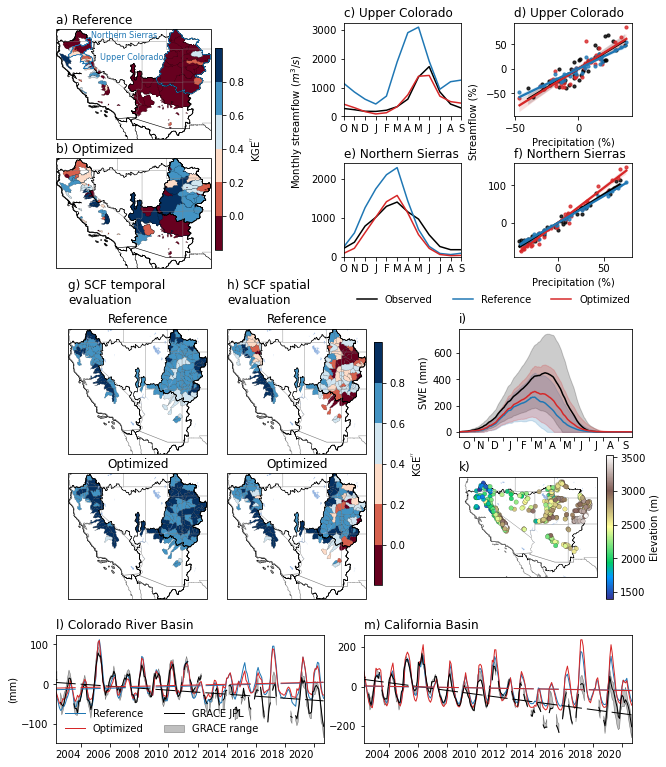

In [33]:
fig = plt.figure(figsize=(8,10))
states_provinces = cfeature.NaturalEarthFeature(category='cultural',
                                                name='admin_1_states_provinces_lines',
                                                scale='50m',
                                                facecolor='none')
extent = (-124.6, -105.6, 30.02, 43.46)

# MAP of KGE''
gs1 = gridspec.GridSpec(2,1)
gs1.update(left=0.,right=.325,top=1.,bottom=.65,wspace=0.05,hspace=0.05)
titles = ['a) Reference', 'b) Optimized']
axes = []
for i,m in zip(range(2), ['ref','opt']):
    ax = plt.subplot(gs1[i],projection=ccrs.PlateCarree())
    ax.set_title(titles[i], loc='left')
    axes += [ax]
    ax.add_feature(states_provinces, edgecolor='grey', lw=.4)
    ax.add_feature(cfeature.BORDERS, edgecolor='k', lw=.6)
    ax.add_feature(cfeature.COASTLINE, edgecolor='k', lw=.6)
    gdf_ucrb_crs.plot(ax=ax, lw=0.6, facecolor='None', edgecolor='k')
    gdf_lcrb_crs.plot(ax=ax, lw=0.6, facecolor='None', edgecolor='k')
    gdf_ca_crs.plot(ax=ax, lw=0.6, facecolor='None', edgecolor='k')
    gdf_sw_crs.plot(ax=ax, lw=0.6, facecolor='None', edgecolor='k')
    ax.set_extent(extent)
    gdf_geoms_union.plot(ax=ax, column=m, cmap=cmap, norm=norm, edgecolor='k', lw=0.1, zorder=-1)
    if i==0:
        gdf_ca_sel.plot(ax=ax, edgecolor='tab:blue', facecolor='None',lw=.6)
        gdf_ucrb_crs.plot(ax=ax, edgecolor='tab:blue', facecolor='None',lw=.6)
        ax.annotate('Northern Sierras', (.225,.925), xycoords='axes fraction', ha='left', color='tab:blue', fontsize=8)
        ax.annotate('Upper Colorado', (.695,.725), xycoords='axes fraction', ha='right', color='tab:blue', fontsize=8)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cb = plt.colorbar(sm, ax=axes,location='right',aspect=30, shrink=.8, ticks=ticks, 
                  extendfrac='auto', extendrect=True, pad=0.02)
cb.set_label(label)

# Hydrographs
gs2 = gridspec.GridSpec(2,2)
gs2.update(left=0.5,right=1.,top=1.,bottom=.675,wspace=0.45,hspace=0.5)
#
ax = plt.subplot(gs2[0,0])
qdict = dict_q_plot['ucrb']
xx_annc = qdict['obs'].groupby("time.month").mean()
yyref_annc = qdict['mdl_ref'].groupby("time.month").mean()
yyopt_annc = qdict['mdl_opt'].groupby("time.month").mean()
months = np.arange(12)
idx = np.append(months[9:], months[:9])
ax.plot(xx_annc.data[idx], c="k", label="Observed")
ax.plot(yyref_annc.data[idx], label="Reference")
ax.plot(yyopt_annc.data[idx], c='tab:red', label="Optimized")
ax.set_xticks(range(12))
ax.set_xticklabels(["O","N","D","J","F","M","A","M","J","J","A","S",])
ax.margins(x=0)
ax.set_ylim(0)
# ax.legend(ncol=1, loc='upper left', frameon=False)
# ax.set_ylabel('Monthly streamflow ($m^3/s$)')
ax.set_title('c) Upper Colorado', loc='left')
#
ax = plt.subplot(gs2[1,0])
qdict = dict_q_plot['ns']
xx_annc = qdict['obs'].groupby("time.month").mean()
yyref_annc = qdict['mdl_ref'].groupby("time.month").mean()
yyopt_annc = qdict['mdl_opt'].groupby("time.month").mean()
months = np.arange(12)
idx = np.append(months[9:], months[:9])
ax.plot(xx_annc.data[idx], c="k", label="Observed")
ax.plot(yyref_annc.data[idx], label="Reference")
ax.plot(yyopt_annc.data[idx], c='tab:red', label="Optimized")
ax.set_xticks(range(12))
ax.set_xticklabels(["O","N","D","J","F","M","A","M","J","J","A","S",])
ax.margins(x=0)
ax.set_ylim(0)
# ax.set_ylabel('Monthly streamflow ($m^3/s$)')
ax.set_title('e) Northern Sierras', loc='left')
ax.annotate('Monthly streamflow ($m^3/s$)', (-.4,1.45), xycoords='axes fraction', rotation=90, ha='center', va='center')

# Sensitivity
ax = plt.subplot(gs2[0,1])
data_dict = dict_sens_plot['ucrb']
sns.regplot(x=data_dict['obs'][0], y=data_dict['obs'][1], ax=ax, color='k', truncate=True, 
            scatter_kws={'s':10}, label='Observed');
sns.regplot(x=data_dict['mdl_opt'][0], y=data_dict['mdl_opt'][1], ax=ax, color='tab:red', truncate=True,
            scatter_kws={'s':10}, label='Optimized');
sns.regplot(x=data_dict['mdl_ref'][0], y=data_dict['mdl_ref'][1], ax=ax, color='tab:blue', truncate=True,
            scatter_kws={'s':10}, label='Reference');
ax.set_ylabel('')
ax.set_xlabel(r'Precipitation (%)')
ax.set_title('d) Upper Colorado', loc='left')
ax.tick_params(which='minor',length=3);
#
ax = plt.subplot(gs2[1,1])
data_dict = dict_sens_plot['ns']
sns.regplot(x=data_dict['obs'][0], y=data_dict['obs'][1], ax=ax, color='k', truncate=True, 
            scatter_kws={'s':10}, label='Observed');
sns.regplot(x=data_dict['mdl_opt'][0], y=data_dict['mdl_opt'][1], ax=ax, color='tab:red', truncate=True,
            scatter_kws={'s':10}, label='Optimized');
sns.regplot(x=data_dict['mdl_ref'][0], y=data_dict['mdl_ref'][1], ax=ax, color='tab:blue', truncate=True,
            scatter_kws={'s':10}, label='Reference');
# ax.set_ylabel(r'Streamflow (%)')
ax.set_xlabel(r'Precipitation (%)')
ax.set_title('f) Northern Sierras', loc='left')
ax.tick_params(which='minor',length=3);
ax.annotate('Streamflow (%)', (-.35,1.45), xycoords='axes fraction', rotation=90, ha='center', va='center')


# SFC
gs3 = gridspec.GridSpec(2,2)
gs3.update(left=0.,right=.65,top=.575,bottom=.2,wspace=0.05,hspace=0.15)  #<<<<<<<<<<<<<<
titles = ['g) SCF temporal \nevaluation', 'h) SCF spatial \nevaluation']
subtitles = ['Reference', 'Optimized']
gs3_axes = []
for i, sim in enumerate(['ref','opt']):
    for j, gdfj in enumerate([gdf_sfc_t, gdf_sfc_sp]):
        ax = plt.subplot(gs3[i,j],projection=ccrs.PlateCarree())
        gs3_axes.append(ax)
        ax.add_feature(states_provinces, edgecolor='gray', lw=.4)
        ax.add_feature(cfeature.BORDERS, edgecolor='gray', lw=.6)
        ax.add_feature(cfeature.LAKES, edgecolor='None', lw=.1)
        ax.add_feature(cfeature.COASTLINE, edgecolor='gray', lw=.6)
        gdf_ucrb_crs.plot(ax=ax, lw=0.6, facecolor='None', edgecolor='k')
        gdf_lcrb_crs.plot(ax=ax, lw=0.6, facecolor='None', edgecolor='k')
        gdf_ca_crs.plot(ax=ax, lw=0.6, facecolor='None', edgecolor='k')
        gdf_sw_crs.plot(ax=ax, lw=0.6, facecolor='None', edgecolor='k')
        ax.set_extent(extent)
        ax.set_title(subtitles[i])
        fc = gdfj.plot(ax=ax, column=sim, cmap=cmap, norm=norm, edgecolor='k', lw=.1, zorder=-1)
        # break
    # break
gs3_axes[0].annotate(titles[0], (0.,1.2), xycoords='axes fraction', ha='left', fontsize=12)
gs3_axes[1].annotate(titles[1], (0.,1.2), xycoords='axes fraction', ha='left', fontsize=12)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cb = plt.colorbar(sm,ax=gs3_axes,location='right',aspect=30, shrink=.9, ticks=ticks, extendfrac='auto', extendrect=True, pad=0.02)
cb.set_label(label)

# SWE
gs4 = gridspec.GridSpec(1,1)
gs4.update(left=0.7,right=1.,top=.575,bottom=.425,wspace=0.1,hspace=0.5) #<<<<<<<<<<<<<<
ax = plt.subplot(gs4[0])
ax.set_title('i)', loc='left')
days = np.arange(365)
idx = np.append(days[273:],days[:273])
monthlength = np.array([31,30,31, 31,28,31,30,31,30,31,31,30])
legend = ['Observed', 'Reference', 'Optimized']
colors = ('k', 'tab:blue', 'tab:red')
for i, m in enumerate(('obs', 'ref', 'opt')): 
    da = swe_plot[m]
    swe_doy = da.groupby('time.dayofyear').mean()
    mu = swe_doy.mean('site')
    sigma = swe_doy.std('site')
    swe_min = swe_doy.min('site')
    swe_max = swe_doy.max('site')
    
    ax.plot(mu.data[idx], label=legend[i], color=colors[i], markersize=2)
    ax.fill_between(days, np.max(np.stack([mu-sigma, np.zeros((mu.size,))]), axis=0)[idx], (mu+sigma)[idx], color=colors[i], alpha=0.2)
    # ax.fill_between(days, swe_min.data[idx], swe_max[idx], color='k', alpha=0.2)
    ax.set_xticks(np.cumsum(monthlength))
    ax.set_xticklabels('')
    ax.set_xticks((monthlength*1.0/2.)+np.cumsum(np.append(0,monthlength)[0:12]), minor=True)
    ax.set_xticklabels(['O','N','D', 'J','F','M','A','M','J','J','A','S',], minor=True);
    ax.tick_params('x',which='minor',length=0)
    ax.margins(x=0)
ax.set_ylabel('SWE (mm)')
ax.legend(ncol=3, loc='upper center', bbox_to_anchor=(.2,1.4), frameon=False)
# ax.legend(ncol=1, loc='upper right', frameon=False)
#
gs4_map = gridspec.GridSpec(1,1)
gs4_map.update(left=0.7,right=1.,top=.4,bottom=.2,wspace=0.1,hspace=0.5) #<<<<<<<<<<<<<<
ax = plt.subplot(gs4_map[0], projection=ccrs.PlateCarree())
ax.set_title('k)', loc='left')
ax.add_feature(states_provinces, edgecolor='gray', lw=.4)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', lw=.6)
ax.add_feature(cfeature.LAKES, edgecolor='None', lw=.1)
ax.add_feature(cfeature.COASTLINE, edgecolor='gray', lw=.6)
gdf_sw_crs.plot(ax=ax, lw=0.6, facecolor='None', edgecolor='k')
yy = swe_stations_sel['latitude'].data[0]
xx = swe_stations_sel['longitude'].data[0]
zz = swe_stations_sel['elevation'].data[0]
sc = ax.scatter(xx, yy, c=zz, cmap='terrain', edgecolor='k', lw=.15, s=20)
cb2 = plt.colorbar(sc, ax=ax)
cb2.set_label('Elevation (m)')

# TWS
gs5 = gridspec.GridSpec(1,2)
gs5.update(left=0.,right=1.,top=.15,bottom=.0,wspace=0.15,hspace=0.)
ax1 = plt.subplot(gs5[0,0])
ax2 = plt.subplot(gs5[0,1])
axes = [ax1, ax2]
months = np.arange(12)
idx = np.append(months[9:],months[:9])
for i, case in enumerate(('CR','CA')):
    ax = axes[i]
    yy_base,yy,da_jpl,da_csr,da_gsfc,time,da_grace = tws_plot[case]
    # ax.axhline(0, c='k', lw=1, ls='--')
    yy_base.plot(ax=ax,lw=1, label='Reference')
    g = yy.plot(ax=ax,lw=1, c='tab:red', label='Optimized')
    da_jpl.plot(ax=ax,lw=1, c='k', label='GRACE JPL')
    # da_csr.plot(c='grey', label='CSR'
    # da_gsfc.plot(c='lightgrey', label='GSFC')
    ax.fill_between(time, da_grace.min('inst'), da_grace.max('inst'), 
                     color='grey',edgecolor='k', lw=.5,alpha=.5, label='GRACE range')
    ax.plot(da_jpl.time, trend_line(da_jpl), '--k', dashes=(20, 5), lw=1)
    ax.plot(yy_base.time, trend_line(yy_base), c='tab:blue', ls='--', dashes=(20, 5), lw=1)
    ax.plot(yy.time, trend_line(yy), c='tab:red', ls='--', dashes=(20, 5), lw=1)

    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=0)
    # ax.set_xticklabels(, rotation=0, ha='center')
    ax.margins(x=0, y=0.05)

    if case=='CR':
        ax.set_title('l) Colorado River Basin', loc='left')
        ax.set_ylabel('(mm)')
    else:
        ax.set_title('m) California Basin', loc='left')
        ax.set_ylabel('')
h,l = ax.get_legend_handles_labels()
ax1.legend(h,l, loc='lower left', ncol=2, frameon=False)

# fig.text(0., 1.1, 'a)', fontsize=16)
# fig.text(0., 1.6, 'b)', fontsize=16)
# fig.text(-0.1, .575, 'b)', fontsize=16)
# fig.text(.45, .7, 'c)', fontsize=16)
# fig.text(-0.1, .275, 'd)', fontsize=16)

In [ ]:
fig.savefig('figs/re_fig_process_eval_annotated_bluetext.png', dpi=600, bbox_inches='tight')